# NLP Project Sectorlense Contract checker

## 1. Introduction and Motivation

Contracts are central to the way businesses operate — especially in the Software-as-a-Service (SaaS) sector, where partnerships, licenses, and service agreements must be handled quickly and at scale. Yet despite the importance of these documents, reviewing them remains largely manual. Legal professionals are expected to carefully check that each contract contains the necessary clauses, uses appropriate wording, and meets legal and regulatory standards. This process is slow, repetitive, and mentally taxing — and the consequences of missing something can be serious: financial penalties, compliance issues, or unclear obligations.

The idea behind this project is simple: legal experts shouldn’t have to spend their time searching for whether a clause exists or whether it “sounds about right.” Instead, we wanted to test whether natural language processing tools — especially large language models (LLMs) — can help handle this first layer of review in a structured, scalable way. Not by replacing legal judgment, but by taking care of the more repetitive checks and surfacing sections that may require closer inspection.

What makes this task even more challenging is that contracts are rarely written in a standard way. Even when two documents aim to cover the same ground, the structure and phrasing can differ significantly. Many companies rely on templates, which can speed things up but also introduce gaps — especially when important clauses are accidentally left out or copied from outdated examples. Inconsistent review processes and pressure to move quickly often increase the likelihood of mistakes.

Our solution builds on a catalogue of key legal requirements — what we call “core aspects” — that are commonly expected in SaaS contracts. These include areas like data protection, liability, service levels, and termination rights. The system processes raw contract text, identifies which paragraphs might correspond to which core aspect, and then uses an LLM to assess how well that paragraph fulfills its intended function.

The overall pipeline includes:

1. **Text Cleaning** – standardizing and preparing the contract for analysis.  
2. **Clause Matching** – comparing each paragraph to the predefined core aspects using sentence embeddings.  
3. **LLM Evaluation** – asking a language model to judge whether the content of the matched paragraph actually meets the requirement, and to what degree.  
4. **Output Structuring** – collecting the results and summarizing them in a way that’s easy to interpret.

This kind of system can’t replace legal expertise — and it’s not meant to. But it can help make reviews more consistent, help surface weak or missing areas more quickly, and reduce the amount of manual work required to get a first impression of a document’s quality. For organizations that deal with a high volume of contracts, or for teams without large legal departments, this could make a real difference.

In [16]:
# ==============================================================================
#  SYSTEM & ENVIRONMENT
# ==============================================================================
import os
import sys
import ssl
import certifi
import random
import pickle
# import time
from pathlib import Path
from dotenv import load_dotenv

# SSL-Config (NLTK, Requests)
ssl._create_default_https_context = lambda: ssl.create_default_context(cafile=certifi.where())

# ==============================================================================
#  DATA HANDLING
# ==============================================================================
import pandas as pd
import numpy as np

# ==============================================================================
#  TEXT PROCESSING & NLP
# ==============================================================================
# import string
# import re
from itertools import chain

import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

import en_core_web_sm

from gensim.parsing.preprocessing import (
    # STOPWORDS,
    # strip_tags,
    # strip_numeric,
    # strip_punctuation,
    # strip_multiple_whitespaces,
    # remove_stopwords,
    # strip_short,
    stem_text
)

from sklearn.feature_extraction.text import CountVectorizer

# ==============================================================================
#  FILE READING & SCRAPING
# ==============================================================================
# import pdfplumber
# import docx
# import requests
# from bs4 import BeautifulSoup

# ==============================================================================
#  VISUALIZATION
# ==============================================================================
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
# from tqdm import tqdm
import ipywidgets as widgets
from IPython.display import display

# ==============================================================================
#  MACHINE LEARNING / DEEP LEARNING
# ==============================================================================
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
from torch.optim import AdamW

from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    accuracy_score,
    f1_score,
    recall_score,
    roc_curve,
    auc
)
from sklearn.metrics.pairwise import cosine_similarity

# Transformers & Sentence Embeddings
from transformers import (
    BertTokenizer,
    # BertModel,
    AutoTokenizer,
    AutoModel,
    # AutoConfig
)

from sentence_transformers import SentenceTransformer, models
from sentence_transformers.models import Pooling

import inspect

# ==============================================================================
#  OPENAI API AND JSON HANDLING
# ==============================================================================
from openai import OpenAI
# import json

# Import API key from parent directory
sys.path.append(os.path.abspath(".."))
from key import OpenAiKey

# ==============================================================================
#  REPRODUCIBILITY
# ==============================================================================
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# ==============================================================================
#  CUSTOM FUNCTIONS AND CLASSES
# ==============================================================================
# File scraping and reading
from functions.function_contract_read_in import (  
    # scrape_html_standard,
    # scrape_html_commonpaper,
    # scrape_html_fakturia,
    # scrape_html_mitratech,
    # scrape_contract_auto,
    read_txt_file
)

# Text preprocessing
from functions.functions_preprocessing import ( 
    extract_paragraphs_and_sections,
    extract_title_fixed,
    clean_sections_and_paragraphs
)

# Embeddings
from functions.functions_embeddings import add_embed_text_column

# Core aspect evaluation
from functions.functions_fullfillment_criteria import (
    # check_core_aspects_with_llm,
    evaluate_fullfillment_on_criteria
)

# Model components
from classes.class_model import CosineMapper
from classes.Class_TextLabelDataset import TextLabelDataset
from classes.class_predictor import SectionTopicPredictor



[nltk_data] Downloading package stopwords to /Users/nils/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## 1. Read in Contracts

The contract checker tool that is going to be created in this project needs to be tested and trained based on some real-world example contracts. Therefore, Sectorelense provided us with an Excel sheet containing a list of various providers of SaaS solutions and links to their websites where sample contracts are available.

These contract documents appear in various formats. Some of them are in HTML, some in PDF, some in DOCX, and some in the format of JSON.

To automate the collection of contracts, our first approach was to try to build an automated scraping tool for each file format.


### Scraping HTML

In our initial implementation, we defined scraping functions for HTML websites directly in the notebook. However, to improve the structure and clarity of our final submission, these scraping functions have now been moved into external modules and are imported when needed. The logic remains unchanged: we use different scraping routines tailored to specific website structures and apply them via a dispatcher function that selects the appropriate strategy based on the URL. This setup allows for flexible extension if additional websites are to be processed later on.

Although we built scraping functions for all provided websites, our final recommendation is to extract text manually and store it in `.txt` files whenever possible. This approach proved to be faster, more reliable, and sufficient for our NLP pipeline.

### Reading in PDF, DOCX, and JSON

During development, we also considered automating the reading of documents in PDF, DOCX, and JSON formats. However, due to the large number of varying structures, we decided against fully automating this step. Writing specific parsers for each file would have introduced unnecessary complexity without clear benefits for our NLP goals. Instead, we manually converted all relevant files to `.txt` format to maintain a uniform input structure.

This pragmatic decision reflects the focus of this project: natural language processing rather than automated document scraping.

### TXT

For reading `.txt` files, a utility function was implemented. This function, too, has now been moved to an external module and is simply imported into the notebook. As a result, the code is no longer directly visible at this point in the notebook, but it continues to fulfill its role in loading text content efficiently and reliably.


### Read mapping

In this step, we load a manually created mapping table in Excel format. The original dataset only contained URLs pointing to various websites where contract texts could be found. However, for consistent processing, we created a custom mapping table.

This table links either to a URL containing the HTML content of a contract, which we aim to scrape automatically,
or to a .txt file name representing a contract we manually extracted.
The .txt files were created by us based on original documents (e.g., .docx or .pdf files). To simplify further processing and ensure a uniform data format, we converted all contracts into plain text files. This approach allows us to handle both web-based and file-based contracts in the same pipeline.

In [2]:
# Load metadata from the mapping Excel file that contains contract sources (e.g., URLs or .txt file names)
list_of_contract_meta = pd.read_excel(Path("../data/input_mapping/Mappingliste_Verträge.xlsx")) 

# Assign the metadata table to a working DataFrame named 'df' for further processing
df = list_of_contract_meta


### Add New Columns to Store Extracted Content and File Type

Before processing the contracts, we ensure that the DataFrame contains the required columns to store extracted data. Specifically, we check for two fields: one to hold the actual contract content, and another to indicate the source format of that content (e.g., whether it was extracted from a local file or scraped from a website).

Originally, this was handled manually or added ad hoc during data manipulation. To make the process more robust and ensure consistent structure when reloading or reusing the notebook, these columns are now initialized conditionally—only if they are not already present.

As the logic for distinguishing between different source formats and file types was moved to external helper functions, this part of the notebook only ensures the DataFrame remains compatible with those imported routines.


In [3]:
# Ensure that the DataFrame has columns to store the extracted contract content and file type.
# These are added only if not already present (e.g., when rerunning the notebook).

if 'Content' not in df.columns:
    df['Content'] = ""

if 'FileType' not in df.columns:
    df['FileType'] = ""


### Load Contract Content from TXT Files or HTML Sources

In this step, we extract the actual contract content for each entry in our mapping table. Originally, this logic was implemented directly in the notebook. However, for better modularization, key functionalities such as reading `.txt` files have been moved to separate modules and are now imported. Therefore, you will no longer see the function implementation here, only the function call.

For each entry, we check whether a local `.txt` file is specified. If so, we load the file using the imported `read_txt_file()` function.

If multiple file references are provided in a single mapping entry, they are concatenated into one content block. The file type is inferred from the first entry and stored in the DataFrame for later use. This step ensures that every contract has a unified representation, regardless of its source.


In [4]:
# Define base directory where local .txt contract files are stored
path_txt_contracts = Path("../data/verträge/verträge_txt")

# Iterate through the mapping table to load content for each contract
for idx, row in df.iterrows():
    mapping_field = row['Mapping']
    content = ""
    file_type = ""

    if pd.notna(mapping_field):
        # Multiple mappings are separated by semicolons (e.g., multiple file references)
        mappings = [m.strip() for m in mapping_field.split(';')]
        texts = []

        for i, mapping in enumerate(mappings):
            if mapping.endswith('.txt'):
                # Extract filename and build path
                filename = Path(mapping).name
                filepath = path_txt_contracts / filename

                # Read .txt file content
                texts.append(read_txt_file(filepath))

                # Store file type based on the first entry
                if i == 0:
                    file_type = "TXT"
            else:
                continue
                # If scraping is needed, the following code could be re-enabled:
                # texts.append(scrape_contract_auto(mapping))
                # if i == 0:
                #     file_type = "HTML"

        # Join all collected texts into a single content block
        content = "\n\n".join(texts)

    # Save content and file type in the DataFrame
    df.at[idx, 'Content'] = content
    df.at[idx, 'FileType'] = file_type

# Create a copy of the final contract list and clean up unused variables
list_of_contracts = df.copy()
del df, list_of_contract_meta, path_txt_contracts

### Translating English Contracts to German Using DeepL API

In this step, all English-language contracts are translated into German to ensure that the entire dataset is in a single language. This simplifies further processing using a monolingual NLP model and helps reduce linguistic complexity, which can lead to improved performance.

The translation is performed using the DeepL API. To use this service, you first need to create a DeepL account (either a free or a Pro version). After registering, your personal API key can be found in the account dashboard. This key should then be stored securely in a `.env` file, typically in the following format:

DEEPL_API_KEY=your_api_key_here


The API key is securely loaded using the `load_dotenv()` function. In addition, the `src` directory is appended to the Python path to allow custom modules to be imported.

For the actual translation process, the built-in `translate_dataframe()` function provided by the DeepL package is used. This function automatically translates only those rows in the DataFrame where the language is marked as `'EN'`, ensuring that already German documents remain unchanged.

It’s also important to note the limitations of the free DeepL API plan: It allows for **up to 50,000 characters per month**. If you exceed this limit, you will either need to upgrade to a paid plan or batch your translations more carefully. Therefore, it is recommended to use the available character quota wisely.

In this notebook, the translation block is commented out by default but can be easily activated if needed.

In [5]:
# Copy the contract list into 'df' for processing
df = list_of_contracts.copy()

# --- Translation pipeline (only activate if really needed/wanted) ---
# Load environment variables (e.g., DeepL API key)
# load_dotenv()

# Add src directory to path to enable custom module import
# sys.path.append(str(Path("..") / "src"))

# Import the translation function from local module
# from translate import translate_dataframe

# Translate contracts that are labeled with language 'EN'
# df = translate_dataframe(df)
# -------------------------------------------------------

# Save translated (or unchanged) contracts into a new DataFrame
list_of_contratcts_translated = df.copy()

# Clean up intermediate variables
del df, list_of_contracts

# Print resulting translated contract list
print(list_of_contratcts_translated)


                                            Kategorie  Quelle/Organisation  \
0                                Verbände / Templates    IT-Recht Hannover   
1                                Verbände / Templates      3H Solutions AG   
2                                Verbände / Templates         Common Paper   
3   Öffentlich zugängliche Verträge großer SaaS-An...                  SAP   
4   Öffentlich zugängliche Verträge großer SaaS-An...                  SAP   
5   Öffentlich zugängliche Verträge großer SaaS-An...                  SAP   
6   Öffentlich zugängliche Verträge großer SaaS-An...               Oracle   
7   Öffentlich zugängliche Verträge großer SaaS-An...    NetSuite (Oracle)   
8   Öffentlich zugängliche Verträge großer SaaS-An...    NetSuite (Oracle)   
9                kleinere SaaS-Anbieter (Hauptgruppe)             Fakturia   
10               kleinere SaaS-Anbieter (Hauptgruppe)               Dräger   
11               kleinere SaaS-Anbieter (Hauptgruppe)           

### Save Translated Input Data as Pickle File

After loading, processing, and translating the contract data, we save the final result to disk for later reuse.

We use the `.pkl` (pickle) format, which is a common and efficient way to store Python objects such as DataFrames. This format allows us to reload the prepared dataset without repeating time-consuming or API-limited preprocessing steps (e.g., reading files, scraping web content, or translating text).

The resulting file `data_scraped_input.pkl` contains all contracts in German—either because they were originally in German or because they were translated. This file serves as the final input for downstream NLP tasks.

> **Note:** Even though all texts are now in German, contracts that were originally in English still retain the label `"EN"` in the `Sprache` column. This makes it easy to filter or analyze translated contracts separately, if needed.


In [6]:
# Define output path for saving the processed contracts as a pickle file
# output_pickle_path = Path("../data/data_scraped_input.pkl")

# Save the translated (or raw) contracts to disk for reuse in later steps
# list_of_contratcts_translated.to_pickle(output_pickle_path)

# Clean up variable(s) no longer needed
del list_of_contratcts_translated  # , output_pickle_path

## 2. Data Cleaning

### 2.1 Data Loading and Initial Structuring

In this first step, we load the dataset from the `.pkl` file generated during the input processing phase (`data_script_input`). This file contains all contract texts — either directly read from `.txt` files or extracted from HTML pages — and, where necessary, translated into German.

Each contract entry in the dataset is enriched with essential metadata, including:

- the source of the data (file or URL)
- the document type (e.g., license agreement, AGB, etc.)
- a mapping to the original source website or filename
- the language of the document (e.g., `'DE'` or `'EN'`)
- the full contract content
- the file type (`TXT` or `HTML`)

> Note: Even translated contracts remain labeled as `"EN"` in the language column. This makes it possible to distinguish between original German documents and translations, which is useful for filtered evaluations later.

This step ensures that all contracts are consistently structured and traceable back to their origin, enabling transparent and reproducible data preparation.

In [7]:
# Load the preprocessed and translated contract data from pickle file
all_contracts_content = pd.read_pickle("../data/data_scraped_input.pkl")

# Display the first few rows for inspection
display(all_contracts_content.head())

# Make a working copy of the loaded data
df = all_contracts_content.copy()

,Kategorie,Quelle/Organisation,Dokumententyp,Mapping,Sprache,Content,FileType
0,Verbände / Templates,IT-Recht Hannover,Muster SaaS-Vertrag,https://it-rechthannover.de/IT-Muster/SaaS-Ver...,DE,§ 1 Vertragsgegenstand 1.1 Der Anbieter stellt...,HTML
1,Verbände / Templates,3H Solutions AG,Standard-Vertragsbedingungen SaaS,Templates_3H_Solutions_AG_18-06_SaaS-Cloudsoft...,DE,Standard-Vertragsbedingungen\nSaaS- und Clouds...,TXT
2,Verbände / Templates,Common Paper,Cloud Service Agreement,https://commonpaper.com/standards/cloud-servic...,EN,1. Service\n1.1. Access and Use. During the Su...,HTML
3,Öffentlich zugängliche Verträge großer SaaS-An...,SAP,NaN,SaaS_SAP_Service_Level_Agreement.txt,DE,SERVICE-LEVEL-VEREINBARUNG FÜR PRIVATE CLOUD E...,TXT
4,Öffentlich zugängliche Verträge großer SaaS-An...,SAP,NaN,Saas_SAP_General_Terms.txt,DE,ALLGEMEINE GESCHÄFTSBEDINGUNGEN FÜR CLOUD SERV...,TXT


**Example of Contract Content:**

In [8]:
# Preview the first 1000 characters of a contract
print(df.iloc[13, 5][:1000] + "...")


Vertragsbedingungen SaaS-Vertrag
der TA Triumph-Adler Gruppe (Stand 01/2021)
Vertragsbedingungen SaaS-Vertrag der TA Triumph-Adler Gruppe
(Stand 01/2021) – Seite 1 von 5
1. Vertragsgegenstand, Anwendungsbereich
1.1. Diese „Vertragsbedingungen SaaS-Vertrag TA Triumph-Adler Gruppe“
(„Vertragsbedingungen“) sind Bestandteil des zwischen Auftragnehmer und
Auftraggeber (gemeinsam „Parteien“) abgeschlossenen Software as a
Service-Vertrags („SaaS-Vertrag“).
1.2. Bestandteil des SaaS-Vertrags sind je nach Vereinbarung im SaaS-Vertrag:
a) die entgeltliche Überlassung folgender Objekte:
- Softwareanwendung mittels Internet, soweit keine anderweitige
Telekommunikation ausdrücklich vereinbart wurde („Services“),
- und/oder
- Software („Vertragssoftware“) einschließlich der zugehörigen Beschreibung
der technischen Funktionalität, des Betriebs, der Installation und der Nutzung,
b) die Erbringung von Serviceleistungen an den Services,
c) die Erbringung von Softwarepflege- und -supportleistungen
(„SPS-

### 2.2 Filter and Select Data

To prepare the dataset for model training, the next step involves filtering the contracts to retain only the content that is actually relevant for downstream modeling. The selection is based on specific criteria, such as including only certain provider groups like “kleinere SaaS-Anbieter (Hauptgruppe)” while potentially excluding others. In the current configuration, this restriction is optional and commented out in the code. What remains active is the filter that ensures only German-language contracts are retained, meaning only rows where the `Sprache` column is set to `DE`.

After filtering, the DataFrame is reduced to just the `content` column, keeping only the full contract text. Additionally, a simple sequential ID column named `contract` is created to uniquely identify each entry. This column is placed at the beginning of the DataFrame to ensure a clean and consistent structure for further processing.

In [9]:
# Filter the dataset to keep only relevant contracts
# Optionally: restrict to a specific category or exclude certain providers
df = df[
    # (df['Kategorie'] == "kleinere SaaS-Anbieter (Hauptgruppe)") &
    (df['Sprache'] == "DE")
    # & (df['Quelle/Organisation'] != "Comarch ERP XT")
]

# Keep only the column containing the contract content
df = df.iloc[:, [5]]
df.columns = ['content']

# Add a unique contract ID column for reference
df["contract"] = range(1, df.shape[0] + 1)

# Reorder columns to: contract ID, then content
df = df[['contract', 'content']]

**Example:**

In [10]:
# Create a copy of the filtered German-only contracts
contract_contents_german_only = df.copy()
print(contract_contents_german_only.head())

# Save the DataFrame as a pickle file for fast reloading later
with open("../data/contract_contents_german_only", "wb") as f:
    pickle.dump(contract_contents_german_only, f)

# Save the same data as an Excel file for manual inspection or documentation
contract_contents_german_only.to_excel("../data/contract_contents_german_only.xlsx", index=False)

# Clean up unused variables
del df, all_contracts_content

   contract                                            content
0         1  § 1 Vertragsgegenstand 1.1 Der Anbieter stellt...
1         2  Standard-Vertragsbedingungen\nSaaS- und Clouds...
3         3  SERVICE-LEVEL-VEREINBARUNG FÜR PRIVATE CLOUD E...
4         4  ALLGEMEINE GESCHÄFTSBEDINGUNGEN FÜR CLOUD SERV...
5         5  SUPPORT SCHEDULE FÜR CLOUD SERVICES\nDieses Su...


### 2.3 Slicing

To enable a more granular analysis, the contract texts are no longer treated as monolithic units but instead are divided into smaller, structured segments. This segmentation step was originally implemented as a complex regular expression directly in the notebook. However, in the current version, we have refactored this logic into a reusable function named `extract_paragraphs_and_sections()`, which is now imported from an external module.

The slicing follows a two-level segmentation logic: First, each contract is split into paragraphs using typical structural markers (e.g., `§ 1`, `1.`). Within each paragraph, further segmentation is performed to extract subsections, identified by patterns like `1.1`, `(1)`, or `1.` depending on the style of the source text.

The function `extract_paragraphs_and_sections()` encapsulates this logic and returns a list of structured rows. Each row contains the contract ID, the full paragraph including its identifier, the section identifier (if available), and the actual text content of that section.

To increase flexibility, the implementation dynamically adapts to the specific structure of each contract and infers the formatting style used. This structured slicing is essential for downstream tasks such as clause classification, similarity comparison, and training NLP models for contract analysis.



#### New Structure: Paragraph and Section Granularity

After defining the `extract_paragraphs_and_sections()` function, we apply it to the filtered dataset `contract_contents_german_only` to decompose each contract into smaller, semantically meaningful segments. This enables us to work at clause-level granularity.

First, we create a copy of the filtered DataFrame to preserve the original data. Then, we apply the slicing function row-wise using `df.apply(...)`, which returns a nested list of paragraph-section dictionaries — one list per contract. Since this nested result structure is not suitable for direct processing, we flatten it into a single list using `itertools.chain.from_iterable()`. This ensures that each paragraph-section unit is transformed into one independent row.

The resulting list of dictionaries is then converted into a new DataFrame, where each row represents one contract section and includes the following metadata: the original contract ID (`contract`), the paragraph identifier (`paragraph`), the section identifier (`section`), and the full content of that section (`section_content`). 

This level of structuring is crucial for downstream tasks that operate at clause level, such as labeling, classification, or question answering.


In [11]:
# Create a working copy of the German-only contracts
df = contract_contents_german_only.copy()

# Apply custom function to extract paragraphs and sections from each contract
sections = df.apply(extract_paragraphs_and_sections, axis=1)
print(sections.head())

# Flatten the list of lists into a single list of rows
rows = list(chain.from_iterable(sections))

# Convert the structured rows into a new DataFrame
df = pd.DataFrame(rows)

0    [{'contract': 1, 'paragraph': '§ 1', 'paragrap...
1    [{'contract': 2, 'paragraph': '§ 1', 'paragrap...
3    [{'contract': 3, 'paragraph': '1.', 'paragraph...
4    [{'contract': 4, 'paragraph': '1.', 'paragraph...
5    [{'contract': 5, 'paragraph': '1.', 'paragraph...
dtype: object


===>

In [12]:
# Save the extracted paragraph and section data into a new DataFrame
contract_sections = df.copy()

# Clean up intermediate variables that are no longer needed
del df, sections, rows

# Display the first 5 rows with contract ID, paragraph, and section for inspection
display(contract_sections[["contract", "paragraph", "section"]].head(5))

,contract,paragraph,section
0,1,§ 1,1.1
1,1,§ 1,1.2
2,1,§ 1,1.3
3,2,§ 1,(1)
4,2,§ 1,(2)


### 2.4 Extracting Paragraph Titles

To derive meaningful titles from each paragraph, we define and apply a custom function called `extract_title_fixed()`, which was modularized and moved into a separate helper module. This function attempts to extract legal-style titles directly from the paragraph content using regular expressions.

Common patterns used to identify titles include typical legal markers such as numbered openings (e.g., `1.`, `§ 1`), introductory keywords (e.g., “Der”, “Ein”, “Eine”), or capitalized phrases that are often formatted as section headers. If these patterns are found, they are extracted as titles.

However, many paragraphs either lack such indicators or use inconsistent formatting. In these cases, a fallback strategy is applied. For standalone paragraphs, a short snippet from the beginning of the paragraph is extracted and used as a provisional title. For paragraphs that contain multiple subsections, the title is reconstructed by removing the full section texts from the paragraph content.

This dual approach guarantees that every paragraph receives a consistent and meaningful title, even if none was explicitly provided in the original document.

To avoid data leakage or model bias during training, we also remove the extracted title from both the `paragraph_content` and `section_content` fields.

The `extract_title_fixed()` function returns a list of titles aligned with the segmented sections in the structured DataFrame.


### 2.5 Finalize Paragraph Titles and Clean Content

After extracting paragraph titles using the `extract_title_fixed()` function, we finalize the structure of our dataset with the following steps:

First, we apply the `extract_title_fixed()` function to each `(contract, paragraph)` group using `groupby(...).apply(...)`. This assigns one title per paragraph and stores the result in a new column called `paragraph_title`.

Next, we reorder and clean the DataFrame to retain only the relevant columns in the desired order:
- `contract`
- `paragraph`
- `paragraph_title`
- `paragraph_content`
- `section`
- `section_content`

To improve clarity, we clean the extracted titles by removing formatting markers like `§ 1` or `1.` from the title strings, ensuring that they are clean and descriptive.

In order to avoid data leakage and prevent the model from memorizing titles during training, we remove the extracted `paragraph_title` from both the `paragraph_content` and `section_content` fields. This ensures that the same title does not appear redundantly within the model input.

The final result is a structured, cleaned DataFrame where each row corresponds to a legally meaningful text unit, ready for downstream analysis.


In [13]:
# Create a working copy of the structured contract sections
df = contract_sections.copy()

# Extract a title for each paragraph and assign it to a new column
# This is done per (contract, paragraph) group using the extract_title_fixed() function
df['paragraph_title'] = df.groupby(['contract', 'paragraph'], group_keys=False).apply(extract_title_fixed)

# Select and reorder relevant columns for downstream use
df = df[['contract', 'paragraph', 'paragraph_title', 'paragraph_content', 'section', 'section_content']]

# Clean extracted paragraph titles by removing the paragraph marker (e.g., "§ 1")
df['paragraph_title'] = df.apply(
    lambda row: row['paragraph_title'].replace(row['paragraph'], '').strip() if pd.notnull(row['paragraph_title']) else '',
    axis=1
)

# Remove the paragraph title from the paragraph content to avoid duplication
df["paragraph_content"] = df.apply(
    lambda row: row["paragraph_content"].replace(row['paragraph_title'], '').strip() if pd.notnull(row["paragraph_content"]) else '',
    axis=1
)

# Also remove the paragraph title from section content to prevent bias in further analysis
df["section_content"] = df.apply(
    lambda row: row["section_content"].replace(row['paragraph_title'], '').strip() if pd.notnull(row["section_content"]) else '',
    axis=1
)

# Save the cleaned structure into a new variable and clear temporary ones
contract_sections_raw = df.copy()
del df, contract_sections

/var/folders/n9/9rvxcg4d1d15_3wh3wq9f0l40000gn/T/ipykernel_74923/4137148649.py:2: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df['paragraph_title'] = df.groupby(['contract', 'paragraph'], group_keys= False).apply(extract_title_fixed)


**New structure**:

In [14]:
# Display the first few rows of the cleaned and structured contract sections
display(contract_sections_raw.head())

# Define the output path for saving the pickle file
output_pickle_path = Path("../data/contract_sections_raw.pkl")

# Save the structured contract sections to disk (both as pickle and Excel)
contract_sections_raw.to_pickle(output_pickle_path)
contract_sections_raw.to_excel("../data/df_contract_sections_raw.xlsx", index=False)

# Clean up variables no longer needed
del contract_sections_raw, output_pickle_path

,contract,paragraph,paragraph_title,paragraph_content,section,section_content
0,1,§ 1,Vertragsgegenstand,§ 1 1.1 Der Anbieter stellt dem Kunden die So...,1.1,1.1 Der Anbieter stellt dem Kunden die Softwar...
1,1,§ 1,Vertragsgegenstand,§ 1 1.1 Der Anbieter stellt dem Kunden die So...,1.2,1.2 Die Nutzung umfasst die Bereitstellung von...
2,1,§ 1,Vertragsgegenstand,§ 1 1.1 Der Anbieter stellt dem Kunden die So...,1.3,1.3 Der Kunde erhält ausschließlich das vertra...
3,2,§ 1,Vertragsgegenstand,§ 1 (1) Dieser Software-as-a-Service-Vertrag ...,(1),(1) Dieser Software-as-a-Service-Vertrag ist a...
4,2,§ 1,Vertragsgegenstand,§ 1 (1) Dieser Software-as-a-Service-Vertrag ...,(2),(2) Die Software wird vom Anbieter als webbasi...


### 2.6 Cleaning Function

In the next step, we focused on cleaning and normalizing the core of the dataset. For this purpose, we implemented a flexible `clean_contract_text()` function that allows us to experiment with various cleaning strategies via function parameters.

The following cleaning options are available:

- Removing all paragraph markers (e.g., “§”, “1.2”)
- Converting all text to lowercase
- Stripping HTML tags
- Removing numbers
- Removing punctuation
- Reducing multiple whitespaces to a single space
- Removing short words (e.g., ≤ 2 characters)
- Removing known stopwords (using Gensim’s stopword library)
- Applying stemming to reduce words to their root form

We tested various combinations of these cleaning options across multiple runs.

> The best results were achieved by enabling all steps **except** stemming, short-word removal, and stopword removal.  
> Stemming in particular was avoided because it tended to distort meaning, which is especially critical in legal language.  
> Stopword removal and short-word filtering were also excluded to preserve as much legal phrasing and semantics as possible.

Therefore, we adopted this configuration as our **standard cleaning pipeline** for all downstream tasks.


**Reading in the structured dataframe**

In [15]:
# Load the structured contract sections from the previously saved pickle file
contract_sections_raw = pd.read_pickle("../data/contract_sections_raw.pkl")

# Display the first few rows to verify the structure
display(contract_sections_raw.head())

# Create a working copy for further processing
df = contract_sections_raw.copy()

,contract,paragraph,paragraph_title,paragraph_content,section,section_content
0,1,§ 1,Vertragsgegenstand,§ 1 1.1 Der Anbieter stellt dem Kunden die So...,1.1,1.1 Der Anbieter stellt dem Kunden die Softwar...
1,1,§ 1,Vertragsgegenstand,§ 1 1.1 Der Anbieter stellt dem Kunden die So...,1.2,1.2 Die Nutzung umfasst die Bereitstellung von...
2,1,§ 1,Vertragsgegenstand,§ 1 1.1 Der Anbieter stellt dem Kunden die So...,1.3,1.3 Der Kunde erhält ausschließlich das vertra...
3,2,§ 1,Vertragsgegenstand,§ 1 (1) Dieser Software-as-a-Service-Vertrag ...,(1),(1) Dieser Software-as-a-Service-Vertrag ist a...
4,2,§ 1,Vertragsgegenstand,§ 1 (1) Dieser Software-as-a-Service-Vertrag ...,(2),(2) Die Software wird vom Anbieter als webbasi...


### 2.7 Applying the Cleaning Function

After defining the modular text cleaning function `clean_contract_text()`, we apply it to both the paragraph-level and section-level content fields in the structured dataset.

By default, the function converts text to lowercase, removes paragraph markers such as "§ 1" or "1.2", strips HTML tags, deletes numbers and punctuation, and collapses multiple spaces into one. These transformations are applied to two new columns: `clean_paragraph_content`, which holds the cleaned version of the full paragraph, and `clean_section_content`, which contains the cleaned version of each section inside the paragraph.

This process ensures the downstream NLP models receive clean and normalized input while retaining the original text in parallel for reference or auditing purposes.


In [16]:
# Apply text cleaning function to paragraph and section content
# This includes steps like removing punctuation, lowercasing, etc.
df["clean_paragraph_content"] = df["paragraph_content"].apply(clean_sections_and_paragraphs)
df["clean_section_content"] = df["section_content"].apply(clean_sections_and_paragraphs)

# Save the cleaned result to a new variable for downstream use
contract_sections_clean = df.copy()

# Clean up intermediate variables
del df, contract_sections_raw

**Example clean paragraph:**

In [17]:
# Print the first 150 characters of the first cleaned paragraph
print(contract_sections_clean["clean_paragraph_content"][0][:150] + "...")


der anbieter stellt dem kunden die software name der software zur verfügung die über eine cloud infrastruktur zugänglich ist die nutzung umfasst die b...


**Example clean section:**

In [18]:
# Print the first 100 characters of the first cleaned section
print(contract_sections_clean["clean_section_content"][0][:100] + "...")

der anbieter stellt dem kunden die software name der software zur verfügung die über eine cloud infr...


### 2.8 Visualizing Token Distributions with Word Clouds

To better understand the most frequent tokens used in our corpus, we visualize word clouds at both the paragraph and section levels. Each word cloud is based on different tokenization strategies to compare how preprocessing steps affect vocabulary representation.

The applied methods include stemming (reducing words to their roots such as “Verträge” becoming “vertrag”), lemmatization using spaCy (which extracts the canonical form of a word with grammatical context), and tokenization with transformer models. For the latter, we use both the BERT tokenizer (uncased) and the multilingual paraphrase tokenizer from the Sentence-Transformer library.

Each method is applied to both the cleaned `paragraph_content` and `section_content` columns to explore differences at different text granularities. This results in eight distinct views across paragraphs and sections.

These views help us identify the most common legal terms and examine tokenization behavior across models. They are particularly useful for understanding how English-language transformer models segment German words, sometimes in unexpected ways.

By viewing the resulting word clouds side by side, we gain intuition about token distributions and validate preprocessing quality. This also highlights the importance of choosing the right model for downstream tasks, especially in multilingual contexts.


In [19]:
# Enable inline plotting in Jupyter
%matplotlib inline

# Load required NLP models and tokenizers
nlp = en_core_web_sm.load()
bert_uncased_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
mlparaphrase_tokenizer = AutoTokenizer.from_pretrained("sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2")

# Create working copy of the cleaned dataset
df = contract_sections_clean.copy()

# --- Preprocessing: Paragraph-level ---

# Apply stemming to paragraph content
df["paragraph_content_stemm"] = df['clean_paragraph_content'].apply(
    lambda text: stem_text(text)
)

# Apply lemmatization using spaCy
df["paragraph_content_lemma"] = df['clean_paragraph_content'].apply(
    lambda text: " ".join([token.lemma_ for token in nlp(text) if not token.is_space])
)

# Tokenize paragraph content using BERT tokenizer (uncased)
df["paragraph_content_token_bert"] = df['clean_paragraph_content'].apply(
    lambda text: bert_uncased_tokenizer.tokenize(text)
)

# Tokenize paragraph content using multilingual paraphrase model tokenizer
df["paragraph_content_token_mlp"] = df['clean_paragraph_content'].apply(
    lambda text: mlparaphrase_tokenizer.tokenize(text)
)

# --- Preprocessing: Section-level ---

# Apply stemming to section content
df["section_content_stemm"] = df['clean_section_content'].apply(
    lambda text: stem_text(text)
)

# Apply lemmatization to section content
df["paragraph_section_lemma"] = df['clean_section_content'].apply(
    lambda text: " ".join([token.lemma_ for token in nlp(text) if not token.is_space])
)

# Tokenize section content using BERT tokenizer
df["paragraph_section_token_bert"] = df['clean_section_content'].apply(
    lambda text: bert_uncased_tokenizer.tokenize(text)
)

# Tokenize section content using multilingual paraphrase model tokenizer
df["paragraph_section_token_mlp"] = df['clean_section_content'].apply(
    lambda text: mlparaphrase_tokenizer.tokenize(text)
)

# --- Word Cloud Visualization Setup ---

# Define which columns to visualize and their display names
columns_and_titles = [
    ("paragraph_content_stemm", "Paragraph – Stemmed"),
    ("paragraph_content_lemma", "Paragraph – Lemmatized"),
    ("paragraph_content_token_bert", "Paragraph – BERT Tokens"),
    ("paragraph_content_token_mlp", "Paragraph – Mulitlingual Paraphrase Tokens"),
    ("section_content_stemm", "Section – Stemmed"),
    ("paragraph_section_lemma", "Section – Lemmatized"),
    ("paragraph_section_token_bert", "Section – BERT Tokens"),
    ("paragraph_section_token_mlp", "Section – Mulitlingual Paraphrase Tokens"),
]

# Prepare individual tabs for each word cloud visualization
tab_contents = []

for col, title in columns_and_titles:
    output = widgets.Output()
    with output:
        # Join tokens for token-based columns, else join raw cleaned text
        if "token" in col:
            all_text = " ".join([" ".join(tokens) if isinstance(tokens, list) else str(tokens)
                                for tokens in df[col].dropna()])
        else:
            all_text = " ".join(df[col].dropna())

        # Generate word cloud
        wordcloud = WordCloud(width=800, height=400, background_color="white").generate(all_text)

        # Plot word cloud
        plt.figure(figsize=(12, 6))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis("off")
        plt.title(f"Wordcloud – {title}", fontsize=16)
        plt.show()
        plt.close()

        tab_contents.append((title, output))

# Create interactive tabs for all word cloud plots
tab_widget = widgets.Tab()
tab_widget.children = [out for _, out in tab_contents]
for idx, (name, _) in enumerate(tab_contents):
    tab_widget.set_title(idx, name)

# Display the tab widget
display(tab_widget)

Token indices sequence length is longer than the specified maximum sequence length for this model (1091 > 512). Running this sequence through the model will result in indexing errors


### 2.9 Saving the Cleaned Contract Dataset

This step concludes the preprocessing pipeline. After cleaning, segmenting, and enriching the contract dataset with paragraph- and section-level structures, we save the final output in two formats.

The dataset is stored as a `.pkl` file (`data_clean.pkl`) for efficient reuse in downstream processing and as an `.xlsx` file (`data_clean.xlsx`) for easy manual inspection or reporting. This ensures the cleaned data is both machine-readable and human-accessible.


In [20]:
# Define output path for saving the final cleaned dataset
file_path = '../data/contract_sections_clean.pkl'

# Save the cleaned contract sections as a pickle file for efficient reuse
contract_sections_clean.to_pickle(file_path)

# Also export the cleaned dataset as an Excel file for manual inspection or reporting
contract_sections_clean.to_excel("../data/data_clean.xlsx", index=False)

# 3. Labeling
## 3.1 Catalog cleaning
In the next step, our goal is to assign labels to as many of our contract sections as possible, based on a predefined requirement catalog.
The requirement catalog consists of the following three components:

- Paragraph Topic: This indicates which paragraph or general area of the contract the requirement refers to.
- Section Topic: A short guiding question that describes the specific aspect or issue that should be addressed within that section of the contract.
- Example Sentence: A concrete example taken from an actual SaaS contract that illustrates how this requirement might typically be formulated in legal language.

This structured setup allows us to later match contract content to catalog entries based on thematic and semantic similarity.

However, before we can map the requirement catalog to our contract data, we first need to clean the example phrases (reference texts) contained within the catalog itself. These examples need to go through the same preprocessing pipeline, such as lowercasing, punctuation removal, and stopword filtering, to ensure that the label mapping is accurate and consistent with the processed contract content.

Only once both the contract data and the catalog examples are cleaned can we begin matching them effectively for label assignment.

**<=== load the raw catalogue**

In [21]:
catalogue_raw = pd.read_excel("../data/catalogue_raw.xlsx")
display(catalogue_raw)
df = catalogue_raw.copy()


,paragraph_topic,section_topic,example
0,Projektkosten & Zahlungsmodalitäten,Sind sämtliche Kostenarten und -bestandteile (...,„Im Festpreis von 200.000 € sind sämtliche Lei...
1,Projektkosten & Zahlungsmodalitäten,Ist das Vergütungsmodell eindeutig festgelegt ...,„Der Kunde zahlt eine monatliche Pauschale von...
2,Projektkosten & Zahlungsmodalitäten,Ist ein Zahlungsplan mit konkreten Fälligkeite...,„Die Vergütung ist in drei Raten zahlbar: 30% ...
3,Projektkosten & Zahlungsmodalitäten,"Sind Währung, Rechnungsstellung, Zahlungsfrist...",„Alle Preise verstehen sich in Euro zuzüglich ...
4,Projektkosten & Zahlungsmodalitäten,Regelt der Vertrag den Umgang mit Nebenkosten ...,„Reise- und Übernachtungskosten werden nur ers...
...,...,...,...
71,Sonstige wichtige Klauseln,Ist die anwendbare Rechtsordnung eindeutig ver...,„Dieser Vertrag unterliegt dem Recht der Bunde...
72,Sonstige wichtige Klauseln,Ist ein Gerichtsstand für Streitigkeiten festg...,„Gerichtsstand für alle Streitigkeiten aus ode...
73,Sonstige wichtige Klauseln,"Bei mehrsprachigen Verträgen: Ist festgelegt, ...",„Dieser Vertrag wird in deutscher und englisch...
74,Sonstige wichtige Klauseln,Enthält der Vertrag eine salvatorische Klausel...,„Sollte eine Bestimmung dieses Vertrages unwir...


clean the catalogue...


In [22]:

df["example"] = df["example"].str.strip('„“"').apply(clean_sections_and_paragraphs)
df["paragraph_topic"] = df["paragraph_topic"].apply(
    lambda x: x.replace("&", 'und').strip().replace(" ","_")
)

catalogue_clean= df.copy()

display(catalogue_clean.head())

file_path = '../data/catalogue_clean.pkl'  
catalogue_clean.to_pickle(file_path)
catalogue_clean.to_excel("../data/catalogue_clean.xlsx", index=False)

del df, catalogue_clean, catalogue_raw

,paragraph_topic,section_topic,example
0,Projektkosten_und_Zahlungsmodalitäten,Sind sämtliche Kostenarten und -bestandteile (...,im festpreis von € sind sämtliche leistungen e...
1,Projektkosten_und_Zahlungsmodalitäten,Ist das Vergütungsmodell eindeutig festgelegt ...,der kunde zahlt eine monatliche pauschale von ...
2,Projektkosten_und_Zahlungsmodalitäten,Ist ein Zahlungsplan mit konkreten Fälligkeite...,die vergütung ist in drei raten zahlbar bei pr...
3,Projektkosten_und_Zahlungsmodalitäten,"Sind Währung, Rechnungsstellung, Zahlungsfrist...",alle preise verstehen sich in euro zuzüglich g...
4,Projektkosten_und_Zahlungsmodalitäten,Regelt der Vertrag den Umgang mit Nebenkosten ...,reise und übernachtungskosten werden nur ersta...


## 3.2 Embedings 
### Reusable Embedding Function for Multiple Models
Since we plan to experiment with various models throughout the project, and each model generates different embeddings, we created a reusable function that adds a new column to a given dataset. This column contains the embeddings computed by the specified model, based on a target text column. This setup allows us to easily switch between models and store their outputs for further analysis or comparison.

## 3.3 Initial Labeling via Embedding Similarity (Deprecated Due to Data Leakage)
Our initial approach was to label the dataset using cosine similarity between contract embeddings and requirement catalog examples, based on a selected model and only doublecheked by a human. The idea was to use these labels later to evaluate and compare different classification models.

However, as the project progressed, we realized that this method introduced data leakage, since the same embeddings used for labeling were also used during model evaluation. To avoid biased results, we decided to abandon this approach in favor of a more robust labeling strategy.

Nevertheless, for the sake of completeness, the original method is documented below.

**<=== load data_clean**


In [23]:
contract_sections_clean_unlabeled = pd.read_pickle('../data/contract_sections_clean.pkl')
catalogue_clean = pd.read_pickle('../data/catalogue_clean.pkl'  )

df = contract_sections_clean_unlabeled


# Set seed and sample data
random.seed(2211)
sample_indices = random.sample(range(len(df["clean_section_content"])), k=600) # Zeiel 600 gelabelte Sections

# Choose the model to evaluate
model_url = "sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2"
model_name = "multilingual_paraphrase_sentence"

# Copy and sample data
df = df.iloc[sample_indices, :].copy()

model_word_embd = models.Transformer(model_url, max_seq_length=512)

pooling_model = models.Pooling(
            model_word_embd.get_word_embedding_dimension(),
            pooling_mode_cls_token=False,           
            pooling_mode_mean_tokens=True,         # ✅ Mean laut chat gpt besser für semantische übereinstimmung
            pooling_mode_max_tokens=False,
        )

model = SentenceTransformer(modules=[model_word_embd, pooling_model])

# Embed contract sections
df = add_embed_text_column(
    df,
    text_column="clean_section_content",
    model= model,
    target_column="section_embeddings"
)

# Embed catalog examples
catalogue = add_embed_text_column(
    catalogue_clean,
    text_column="example",
    model=model,
    target_column="example_ebeddings"
)

# Keep only relevant columns
df = df[["contract", "paragraph", "section", "clean_section_content", "section_embeddings"]]

# Compute cosine similarity
X = np.vstack(df["section_embeddings"].values)
Y = np.vstack(catalogue["example_ebeddings"].values)

similarity_matrix = cosine_similarity(X, Y)
similarity_percent = np.round(similarity_matrix * 100, 2)

# Best matches per section
best_match_idx = similarity_matrix.argmax(axis=1)
best_match_score = similarity_percent[np.arange(len(X)), best_match_idx]

# Store results
df[f"matched_example_index"]    = best_match_idx
df[f"similarity_percent"]       = best_match_score
df[f"matched_example_text"]     = catalogue.loc[best_match_idx, "example"].values
df[f"matched_example_topic"]    = catalogue.loc[best_match_idx, "section_topic"].values
df[f"matched_paragraph"]        = catalogue.loc[best_match_idx, "paragraph_topic"].values

# Summary stats
print(f"# {model_name}")
print("    mean similarity:",   df["similarity_percent"].mean())
print("    max similarity:",    df["similarity_percent"].max())
print("    min similarity:",    df["similarity_percent"].min())

# Example: best and worst match
df = df.sort_values(f"similarity_percent", ascending=False)
best_match = df.iloc[0]
print("\nBest match:")
print(f'{best_match["clean_section_content"]} \n### to ### \n{best_match["matched_example_text"]} \n### with score ### {best_match["similarity_percent"]}')

df = df.sort_values(f"similarity_percent", ascending=True)
worst_match = df.iloc[0]
print("\nWorst match:")
print(f'{worst_match["clean_section_content"]} \n### to ### \n{worst_match["matched_example_text"]} \n### with score ### {worst_match["similarity_percent"]}')

contract_sections_clean_labeled_600 = df.copy()
del df, catalogue_clean, contract_sections_clean_unlabeled

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Embedding example: 100%|██████████| 5/5 [00:00<00:00,  5.15it/s]

# multilingual_paraphrase_sentence
    mean similarity: 66.95322
    max similarity: 95.97
    min similarity: 22.23

Best match:
sollten einzelne bestimmungen dieses vertrags ganz oder teilweise unwirksam sein oder werden wird die wirksamkeit der übrigen bestimmungen hierdurch nicht berührt die parteien verpflichten sich für diesen fall die ungültige bestimmung durch eine wirksame bestimmung zu ersetzen die dem wirtschaftlichen zweck der ungültigen bestimmung möglichst nahekommt entsprechendes gilt für etwaige lücken dieser bedingungen 
### to ### 
sollte eine bestimmung dieses vertrages unwirksam oder undurchführbar sein oder werden bleibt die wirksamkeit der übrigen bestimmungen hiervon unberührt die parteien werden die unwirksame bestimmung einvernehmlich durch eine solche regelung ersetzen die dem wirtschaftlichen zweck der unwirksamen bestimmung am nächsten kommt 
### with score ### 95.97000122070312

Worst match:
allgemeinen geschäftsbedingungen für die comarch service produkte 

This results in a dataset containing the best matches between contract sections and catalog examples for mulitlingual paraphrase models.

In [24]:
display(contract_sections_clean_labeled_600 .sort_values(f"similarity_percent", ascending=False).head(5))
del contract_sections_clean_labeled_600 # Sackgasse

,contract,paragraph,section,clean_section_content,section_embeddings,matched_example_index,similarity_percent,matched_example_text,matched_example_topic,matched_paragraph
305,8,15.,15.5,sollten einzelne bestimmungen dieses vertrags ...,"[-0.0041314946, 0.096693866, -0.13690825, -0.0...",74,95.970001,sollte eine bestimmung dieses vertrages unwirk...,Enthält der Vertrag eine salvatorische Klausel...,Sonstige_wichtige_Klauseln
683,16,14.,14.2,der vertrag untersteht dem recht der bundesrep...,"[-0.09444846, 0.19770819, -0.38321418, -0.1446...",71,93.180000,dieser vertrag unterliegt dem recht der bundes...,Ist die anwendbare Rechtsordnung eindeutig ver...,Sonstige_wichtige_Klauseln
142,6,4.,4.1,aufgrund dieses vertrags dürfen die parteien s...,"[-0.05984672, 0.04162008, -0.55982614, -0.0669...",35,93.180000,die parteien verpflichten sich alle ihnen im r...,Enthält der Vertrag eine beidseitige Vertrauli...,Datenschutz_und_Informationssicherheit
1219,24,§ 19,19.3,sollten teile dieses vertrages ganz oder teilw...,"[-0.076217115, 0.06346369, -0.16947885, 0.0086...",74,92.820000,sollte eine bestimmung dieses vertrages unwirk...,Enthält der Vertrag eine salvatorische Klausel...,Sonstige_wichtige_Klauseln
286,8,11.,11.1,die parteien verpflichten sich alle vertraulic...,"[-0.052296683, 0.086999364, -0.53502244, -0.11...",35,92.269997,die parteien verpflichten sich alle ihnen im r...,Enthält der Vertrag eine beidseitige Vertrauli...,Datenschutz_und_Informationssicherheit


## 3.4 Manual mapping

However, as previously mentioned, the automatic labeling approach introduced data leakage. Therefore, we changed our strategy and switched to manual labeling of as many data points as possible.

Since this process is extremely time-consuming, and we are not legal experts — even in our native language, German — we were only able to manually label a total of 64 data samples.

Another challenge we encountered was that, although we had compiled a dataset of over 1,300 contract sections, we were unable to find suitable matches for all examples in the requirements catalog. As a result, 12 out of the 76 requirement items remain without any corresponding training data.

In essence, we manually reviewed all available contracts and initially searched for relevant keywords to identify potential matches. Once potential sections were found, we compared them directly to the example sections in the requirement catalog.

Only when we were 100% confident that a contract section semantically matched a catalog entry did we assign the corresponding catalog ID (i.e., the position of the example section within the catalog) to that contract section.

The following table shows a selection of sections from our dataset that have been mapped to their corresponding catalog_id (i.e., the index of the requirements catalog).

In [25]:

contract_sections_clean_labeled_manually = pd.read_excel("../data/sections_labeled_manually.xlsx") 
display(contract_sections_clean_labeled_manually.head(5))


,Unnamed: 0,contract,paragraph,section,section_content,clean_section_content,catalog_id
0,0,2,§ 7,(1),(1) Zahlungszeitraum und Höhe der richten sic...,zahlungszeitraum und höhe der richten sich ebe...,1
1,1,2,§ 12,(2),(2) Die außerordentliche Kündigung aus wichtig...,die außerordentliche kündigung aus wichtigem g...,69
2,2,4,3.,3.2,3.2. Support und SLA 3.2.1. SAP erbringt Suppo...,support und sla sap erbringt support für den c...,31
3,3,4,5.,5.2,5.2. Alle Vergütungen unterliegen den jeweils ...,alle vergütungen unterliegen den jeweils anwen...,8
4,4,4,6.,6.3,6.3. Im Falle einer Kündigung des Auftraggeber...,im falle einer kündigung des auftraggebers ode...,70


catalog and labels sections can be compared by the catlog id.......

In [26]:
catalogue_clean = pd.read_pickle("../data/catalogue_clean.pkl")
catalogue_clean["catalog_id"] = range(1, len(catalogue) + 1)
display(catalogue_clean.head(5))

,paragraph_topic,section_topic,example,catalog_id
0,Projektkosten_und_Zahlungsmodalitäten,Sind sämtliche Kostenarten und -bestandteile (...,im festpreis von € sind sämtliche leistungen e...,1
1,Projektkosten_und_Zahlungsmodalitäten,Ist das Vergütungsmodell eindeutig festgelegt ...,der kunde zahlt eine monatliche pauschale von ...,2
2,Projektkosten_und_Zahlungsmodalitäten,Ist ein Zahlungsplan mit konkreten Fälligkeite...,die vergütung ist in drei raten zahlbar bei pr...,3
3,Projektkosten_und_Zahlungsmodalitäten,"Sind Währung, Rechnungsstellung, Zahlungsfrist...",alle preise verstehen sich in euro zuzüglich g...,4
4,Projektkosten_und_Zahlungsmodalitäten,Regelt der Vertrag den Umgang mit Nebenkosten ...,reise und übernachtungskosten werden nur ersta...,5


# 4. Model Comparrison & Evaluation
We now move on to selecting the most suitable model. In total, we chose five different models from Hugging Face, all of which are Sentence Transformers, each with a corresponding tokenizer:

- "deepset/gbert-base"
- "sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2"
- "bert-base-uncased",
- "jinaai/jina-embeddings-v2-small-en",
- "jinaai/jina-embeddings-v2-base-de",


Additionally, we need to decide on a pooling strategy. This strategy determines how we aggregate token-level embeddings into a single section-level embedding, which is essential for comparing sections rather than individual words.
When generating embeddings for full sections using transformer-based models, we must reduce the token-level output to a single fixed-size vector. This process is called pooling. Two common strategies are:

**CLS Token Pooling**
Uses the embedding of the special [CLS] token, which is prepended to every input by models like BERT.
The [CLS] token is explicitly trained (during pretraining) to capture the meaning of the entire sentence for classification tasks.
Advantage: In models trained for classification (e.g. BERT), the CLS token often encodes global sentence-level semantics efficiently.

**Mean Pooling**
Averages the embeddings of all tokens (excluding padding).
Provides a more balanced representation of the entire sentence or section.
Advantage: Especially useful in models not fine-tuned with CLS-specific objectives (e.g. multilingual or paraphrase models), where the semantic information is more evenly distributed across all tokens.

**Max Pooling**
Takes the maximum value across all token embeddings for each embedding dimension (excluding padding).
This emphasizes the most salient features that appear anywhere in the input, regardless of position.

Advantage: Max pooling can highlight strong semantic signals (e.g. key terms) by preserving their peak activations. This may be beneficial in tasks where individual high-impact words (rather than holistic meaning) are important — especially in longer or noisy texts.



## 4.1 Tokenizers and Embeddings

Toenizers ALSJdylxcnyx

In [27]:
from transformers import logging
logging.set_verbosity_error()
model_names = [
    "gbert-base",
    "paraphrase-multilingual-MiniLM-L12-v2",
    "bert-base-uncased",
    "jina-embeddings-v2-small-en",
    "jina-embeddings-v2-base-de"
]

model_urls = [
    "deepset/gbert-base",
    "sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2",
    "bert-base-uncased",
    "jinaai/jina-embeddings-v2-small-en",
    "jinaai/jina-embeddings-v2-base-de"
]


max_tokens = []

for model_name, model_url in zip(model_names, model_urls):
   
    model_to_test= AutoModel.from_pretrained(model_url)
    
    max_len = model_to_test.embeddings.position_embeddings.weight.shape[0]
    max_tokens.append((model_name, max_len))

# DataFrame erstellen
max_tokens_per_model = pd.DataFrame(max_tokens, columns=["model_name", "max_token"])#.sort_values(max_tokens, ascending = True)

# Anzeigen
display(max_tokens_per_model)
del max_tokens_per_model,  max_tokens, model_to_test


,model_name,max_token
0,gbert-base,512
1,paraphrase-multilingual-MiniLM-L12-v2,512
2,bert-base-uncased,512
3,jina-embeddings-v2-small-en,8192
4,jina-embeddings-v2-base-de,8192


lets compare the amount of generated toekns:

In [28]:
contract_sections_clean = pd.read_pickle('../data/contract_sections_clean.pkl')
df = contract_sections_clean.copy()

tokenizers = {}

for name, url in zip(model_names, model_urls):
    tokenizers[name] = AutoTokenizer.from_pretrained(url)

# Tokenlängen erfassen
token_counts = {}

for name, tokenizer in tokenizers.items():
    token_counts[name] = df["clean_section_content"].fillna("").apply(lambda x: len(tokenizer.tokenize(x)))

# Plot: Verteilung der Tokenanzahl (99%-Quantil)


The following diagram shows how many tokens the various language models generate for the texts in our dataset. It is clearly noticeable that English-based models tend to produce a higher token density, especially for longer texts. A likely reason for this is that German words are not well represented in the English vocabulary, which leads to more frequent splitting into subword tokens.

The two models bert-base-uncase and jina-embeddings-v2-small-en generate much more tokens per text segment compared to the German-language models such as gbert-base and jina-embeddings-v2-base-de.

Nevertheless, all models, including the English ones, achieve consistently solid performance. The fact that many texts exceed the maximum token input size of the respective models (e.g., 512 for BERT) does not pose a problem for our use case, as we handle this through appropriate truncation or segmentation strategies.

Overall, the results indicate that German-language models are better suited for processing German texts, as they require fewer splits and better capture the language’s structure. For our dataset of over 1,300 section texts, language-specific models such as gbert-base, jina-base-de or paraphrase-multilingual-MiniLM-L12-v2 (mulitlingual) prove to be particularly effective.

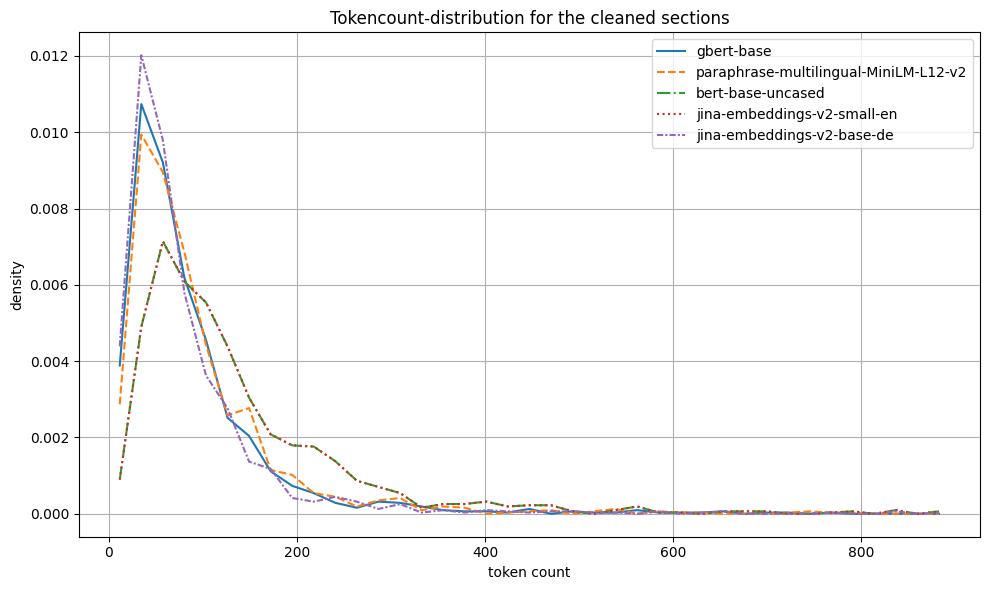

In [29]:
plt.figure(figsize=(10, 6))
max_x = max(token_counts[name].quantile(0.99) for name in token_counts)
bins = np.linspace(0, max_x, 40)
styles = ['-', '--', '-.', ':', (0, (3, 1, 1, 1))]


for (name, data), style in zip(token_counts.items(), styles):
    hist, bin_edges = np.histogram(data, bins=bins, density=True)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    plt.plot(bin_centers, hist, label=name, linestyle=style)

plt.title(f"Tokencount-distribution for the cleaned sections")
plt.xlabel("token count")
plt.ylabel("density")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

del  max_x , df, bins, styles, hist, bin_centers, bin_edges, token_counts, tokenizers

## 4.2 Model Assembly and Pooling start
In this section, we load a selection of transformer-based language models and prepare them for use with the Sentence Transformers framework. Each model is wrapped with a pooling strategy to generate fixed-size sentence embeddings.
Each model is assembled using the Sentence Transformers Transformer + Pooling modules. We store each configuration in a dictionary (models_dict) using a key that includes the model name and pooling strategy (e.g., base_gbert_sentence_cls).
If the RAM is not sufficient there is also the Option to safe all the build models for reuse without reloading from Hugging Face however when doing so they have to be excluded from the git repository since they are to big.
This setup provides a flexible and consistent framework to benchmark **15 different transformer** models and pooling strategies for downstream semantic matching tasks.


In [30]:
models_store_as = [
    "base_gbert_sentence",
    "multilingual_paraphrase_sentence",
    "bert_base_uncased_sentence",
    "jina_small_en_sentence",
    "jina_base_de_sentence",
]

pool_strats = ["cls", "mean", "max"]

# Dictionary zur Sammlung der Modelle
models_dict = {}
models_urls = {}
models_strat = {}


for model_in, model_out in zip(model_urls, models_store_as):
    word_embedding_model = models.Transformer(model_in, max_seq_length=512)

    for pool_strat in pool_strats:
        print(f"Assable model: {model_out}, with word-embedding-odel: '{model_in}' and pooling strategy: {pool_strat}")

        cls = pool_strat == "cls"
        mean = pool_strat == "mean"
        maxi = pool_strat == "max"

        pooling_model = models.Pooling(
            word_embedding_model.get_word_embedding_dimension(),
            pooling_mode_cls_token=cls,
            pooling_mode_mean_tokens=mean,
            pooling_mode_max_tokens=maxi,
        )

        model_section_embedding= SentenceTransformer(modules=[word_embedding_model, pooling_model])

        # Key z. B. "base_gbert_sentence_cls"
        dict_key = f"{model_out}_{pool_strat}"
        models_dict[dict_key] = model_section_embedding
        models_urls[dict_key] = model_in
        models_strat[dict_key] = pool_strat


        # Optional speichern:
        # model.save(f"../models/raw_STM/{dict_key}_emb")

# Ausgabe der geladenen Modelle
print("loaded models:", list(models_dict.keys()))


Assable model: base_gbert_sentence, with word-embedding-odel: 'deepset/gbert-base' and pooling strategy: cls
Assable model: base_gbert_sentence, with word-embedding-odel: 'deepset/gbert-base' and pooling strategy: mean
Assable model: base_gbert_sentence, with word-embedding-odel: 'deepset/gbert-base' and pooling strategy: max
Assable model: multilingual_paraphrase_sentence, with word-embedding-odel: 'sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2' and pooling strategy: cls
Assable model: multilingual_paraphrase_sentence, with word-embedding-odel: 'sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2' and pooling strategy: mean
Assable model: multilingual_paraphrase_sentence, with word-embedding-odel: 'sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2' and pooling strategy: max
Assable model: bert_base_uncased_sentence, with word-embedding-odel: 'bert-base-uncased' and pooling strategy: cls
Assable model: bert_base_uncased_sentence, with word-embedding-odel

## 4.3 Matching Contract Sections to Catalog Entries Using Embeddings

shjdfhskdjfh prdict and  compare

In [31]:

df = contract_sections_clean_labeled_manually.copy()
df_no_label = df[["contract","paragraph","section","clean_section_content"]].copy()
display(df_no_label)


,contract,paragraph,section,clean_section_content
0,2,§ 7,(1),zahlungszeitraum und höhe der richten sich ebe...
1,2,§ 12,(2),die außerordentliche kündigung aus wichtigem g...
2,4,3.,3.2,support und sla sap erbringt support für den c...
3,4,5.,5.2,alle vergütungen unterliegen den jeweils anwen...
4,4,6.,6.3,im falle einer kündigung des auftraggebers ode...
...,...,...,...,...
59,26,16.,16.1,das vertragsverhältnis beginnt mit dem zugang ...
60,26,17.,17.1,vorzeitige beendigung des vertrages wegen wech...
61,26,17.,17.3,pflichten von sellers sellers unterstützt den ...
62,26,17.,17.6,datenlöschung nach vollzug des wechsels seller...


In [32]:

df_true_label = df[["contract","paragraph","section","clean_section_content","catalog_id"]].copy()
df_true_label.rename(columns={"catalog_id": "true_catalog_id"},inplace= True)
display(df_true_label)


,contract,paragraph,section,clean_section_content,true_catalog_id
0,2,§ 7,(1),zahlungszeitraum und höhe der richten sich ebe...,1
1,2,§ 12,(2),die außerordentliche kündigung aus wichtigem g...,69
2,4,3.,3.2,support und sla sap erbringt support für den c...,31
3,4,5.,5.2,alle vergütungen unterliegen den jeweils anwen...,8
4,4,6.,6.3,im falle einer kündigung des auftraggebers ode...,70
...,...,...,...,...,...
59,26,16.,16.1,das vertragsverhältnis beginnt mit dem zugang ...,68
60,26,17.,17.1,vorzeitige beendigung des vertrages wegen wech...,57
61,26,17.,17.3,pflichten von sellers sellers unterstützt den ...,58
62,26,17.,17.6,datenlöschung nach vollzug des wechsels seller...,59


asdfcadyx 

In [33]:


df_true_label["true_catalog_id"] = df_true_label["true_catalog_id"].astype(int)
cols = ["contract","paragraph","section","clean_section_content"]
display(catalogue_clean)

del df



,paragraph_topic,section_topic,example,catalog_id
0,Projektkosten_und_Zahlungsmodalitäten,Sind sämtliche Kostenarten und -bestandteile (...,im festpreis von € sind sämtliche leistungen e...,1
1,Projektkosten_und_Zahlungsmodalitäten,Ist das Vergütungsmodell eindeutig festgelegt ...,der kunde zahlt eine monatliche pauschale von ...,2
2,Projektkosten_und_Zahlungsmodalitäten,Ist ein Zahlungsplan mit konkreten Fälligkeite...,die vergütung ist in drei raten zahlbar bei pr...,3
3,Projektkosten_und_Zahlungsmodalitäten,"Sind Währung, Rechnungsstellung, Zahlungsfrist...",alle preise verstehen sich in euro zuzüglich g...,4
4,Projektkosten_und_Zahlungsmodalitäten,Regelt der Vertrag den Umgang mit Nebenkosten ...,reise und übernachtungskosten werden nur ersta...,5
...,...,...,...,...
71,Sonstige_wichtige_Klauseln,Ist die anwendbare Rechtsordnung eindeutig ver...,dieser vertrag unterliegt dem recht der bundes...,72
72,Sonstige_wichtige_Klauseln,Ist ein Gerichtsstand für Streitigkeiten festg...,gerichtsstand für alle streitigkeiten aus oder...,73
73,Sonstige_wichtige_Klauseln,"Bei mehrsprachigen Verträgen: Ist festgelegt, ...",dieser vertrag wird in deutscher und englische...,74
74,Sonstige_wichtige_Klauseln,Enthält der Vertrag eine salvatorische Klausel...,sollte eine bestimmung dieses vertrages unwirk...,75


# Comparison
In this section, we match contract sections to the most relevant catalog entries using vector-based semantic similarity. For each embedding model in our comparison, we perform the following steps:

Embedding Generation:
We encode the contract sections (clean_section_content) and the catalog examples (example) using the selected embedding model.

Similarity Computation:
We calculate the cosine similarity between each section embedding and all catalog entry embeddings. For each section, we select the catalog entry with the highest similarity score as the predicted match.

Ground Truth Comparison:
We compare the predicted catalog ID against the ground truth (true_catalog_id) to assess whether the top match is correct.

Evaluation with ROC Curve:
Using the cosine similarity scores as prediction confidence, we compute an ROC curve and the AUC (Area Under Curve) to measure how well the model distinguishes correct from incorrect matches.

Threshold Optimization:
We determine an optimal similarity threshold based on the ROC curve (max(TPR - 0.5 × FPR)), which we then use to classify matches as valid or invalid.

Postprocessing:
Matches below the threshold are marked as invalid by assigning a dummy catalog ID (-99), enabling further analysis and filtering.

This analysis is repeated for each model in our benchmark set. The results help us compare model performance and select the best embedding model for semantic contract section matching.

In [34]:

models_thresholds = {}
tab_contents = []
df = df_no_label.copy()
df_cols = ["contract","paragraph","section","clean_section_content"]

for model_name in models_dict:
    model_selected = models_dict[model_name]
    df = add_embed_text_column(df, text_column="clean_section_content",model = model_selected, target_column=f"section_em_{model_name}")
    cat = add_embed_text_column(catalogue_clean, text_column = "example", model = model_selected, target_column = "emb")
    df_cols.append(f"section_em_{model_name}")
    #df  = df[df_cols]

    X = np.vstack(df[f"section_em_{model_name}" ].values)  # Shape: [1400, 768]
    Y = np.vstack(cat["emb"].values)                  # Shape: [100, 768]

    # Cosine Similarity: alle Kombinationen
    similarity_matrix = cosine_similarity(X, Y)  # Shape: [1400, 100]
    similarity_percent = np.round(similarity_matrix * 100, 2)  # Skaliert zu 0–100 %

    best_match_idx = similarity_matrix.argmax(axis=1)
    best_match_score = similarity_percent[np.arange(len(X)), best_match_idx]

    # Ergebnisse anhängen
    new_cols = pd.DataFrame({
    f"matched_example_index_{model_name}": best_match_idx,
    f"similarity_percent_{model_name}": best_match_score,
    f"matched_example_text_{model_name}": cat.loc[best_match_idx, "example"].values,
    f"matched_example_topic_{model_name}": cat.loc[best_match_idx, "section_topic"].values,
    f"matched_paragraph_{model_name}": cat.loc[best_match_idx, "paragraph_topic"].values,
    f"matched_catalog_id_{model_name}": cat.loc[best_match_idx, "catalog_id"].values,
    })

    df = pd.concat([df.reset_index(drop=True), new_cols.reset_index(drop=True)], axis=1)
    del new_cols

    # # print(df_true_match["true_catalog_id"].dtype)
    # print(df_to_match[f"matched_catalog_id_{model_name}"].dtype)    
    df_pred_label = df

    y_true = (df_true_label["true_catalog_id"].values == df_pred_label[f"matched_catalog_id_{model_name}"].values).astype(int)
    if np.sum(y_true) == 0:
        print(f"No match found at all with model: {model_name}")
    y_scores = df_pred_label[f"similarity_percent_{model_name}"].values / 100  # zurück zu 0–1
    # print("Verteilung der Klassen in y_true:")
    # print(np.unique(y_true, return_counts=True)) U+1F644



    # ROC-Kurve
    fpr, tpr, thresholds = roc_curve(y_true, y_scores)
    roc_auc = auc(fpr, tpr)
    custom_score = tpr - 0.5 * fpr
    optimal_idx = np.argmax(custom_score)
    optimal_threshold = thresholds[optimal_idx]
    
    output = widgets.Output()
    with output:
        plt.figure(figsize=(8, 6))
        plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})')
        plt.plot([0, 1], [0, 1], 'k--')  # Diagonale
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'ROC Curve - {model_name}')
        plt.plot(fpr[optimal_idx], tpr[optimal_idx], 'ro', label='Optimal Threshold')
        plt.legend(loc='lower right')
        plt.legend(loc='lower right')
        plt.grid(True)
        plt.show()

        tab_contents.append((title, output))
    # Optimaler Threshold = max(tpr - fpr)

    # print(f"Optimaler Threshold für Cosine Similarity (%): {optimal_threshold * 100:.2f}")
    # Neue Spalte: Match nur wenn Score >= Threshold
    df[f"match_valid_{model_name}"] = y_scores >= optimal_threshold
    df.loc[~df[f"match_valid_{model_name}"], f"matched_catalog_id_{model_name}"] = -99
    del y_true , y_scores
    models_thresholds[model_name] = optimal_threshold

tab_widget = widgets.Tab()
tab_widget.children = [out for _, out in tab_contents]
for idx, (name, _) in enumerate(tab_contents):
    tab_widget.set_title(idx, name)
display(tab_widget)


matches_all_models = df.copy()
del df, df_cols ,df_pred_label, optimal_threshold, optimal_idx, fpr, tpr, thresholds, tab_widget, X,Y, similarity_matrix, similarity_percent, best_match_idx, best_match_score


Embedding example: 100%|██████████| 5/5 [00:01<00:00,  2.81it/s]


Embedding example: 100%|██████████| 5/5 [00:01<00:00,  2.58it/s]


Embedding example: 100%|██████████| 5/5 [00:01<00:00,  2.52it/s]


Embedding example: 100%|██████████| 5/5 [00:00<00:00,  5.10it/s]


Embedding example: 100%|██████████| 5/5 [00:00<00:00,  5.58it/s]


Embedding example: 100%|██████████| 5/5 [00:00<00:00,  5.60it/s]


Embedding example: 100%|██████████| 5/5 [00:03<00:00,  1.50it/s]


Embedding example: 100%|██████████| 5/5 [00:03<00:00,  1.50it/s]


Embedding example: 100%|██████████| 5/5 [00:03<00:00,  1.33it/s]


Embedding example: 100%|██████████| 5/5 [00:00<00:00,  7.20it/s]


Embedding example: 100%|██████████| 5/5 [00:00<00:00,  6.51it/s]


Embedding example: 100%|██████████| 5/5 [00:00<00:00,  7.22it/s]


Embedding example: 100%|██████████| 5/5 [00:01<00:00,  2.64it/s]


Embedding example: 100%|██████████| 5/5 [00:01<00:00,  2.79it/s]


Embedding example: 100%|██████████| 5/5 [00:01<00:00,  2.67it/s]


# Classification

In [35]:
df = matches_all_models.copy()

import warnings
from sklearn.exceptions import UndefinedMetricWarning

warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=UndefinedMetricWarning)

df = matches_all_models.copy()
tabs = []
titles = []
recalls_weighted = []

for model_name in models_dict:
    pred_col = f"matched_catalog_id_{model_name}"
    y_true = df_true_label["true_catalog_id"]
    y_pred = df[pred_col]

    # Berechne recall (weighted)
    recall_w = recall_score(y_true, y_pred, average='weighted')
    recalls_weighted.append(recall_w)

    output = widgets.Output()
    with output:
        print(f"Classification Report for {model_name}")
        print(classification_report(y_true, y_pred, digits=2))

    tabs.append(output)
    titles.append(model_name)

best_recall_idx = int(max(range(len(recalls_weighted)), key=lambda i: recalls_weighted[i]))


# Tab-Widget erzeugen
tab_widget = widgets.Tab(children=tabs)
for i, title in enumerate(titles):
    tab_widget.set_title(i, title)

display(tab_widget)
del df, tabs, titles, pred_col, y_true, y_pred,  tab_widget, recalls_weighted, model_name, output, best_recall_idx,  i, title


# Confusion

In [36]:
tab_contents = []
df = matches_all_models.copy()

for model_name in models_dict:
    output = widgets.Output()
    with output:
        # Daten vorbereiten
        df_matched_ids = df[["contract", "paragraph", "section", "clean_section_content", f"matched_catalog_id_{model_name}"]]
        y_true = df_true_label["true_catalog_id"].astype(str)
        y_pred = df[f"matched_catalog_id_{model_name}"].astype(str)

        # Gemeinsame, sortierte Label-Liste für Achsen
        # Gemeinsame Labels sammeln
        all_labels_set = set(y_true).union(set(y_pred))

        # Nach int sortieren, dann in String zurückwandeln
        all_labels = [str(x) for x in sorted(map(int, all_labels_set))]
        cm = confusion_matrix(y_true, y_pred, labels=all_labels)

        # Plot
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=False, fmt="d", cmap="Blues",
                    xticklabels=all_labels, 
                    yticklabels=all_labels)
        plt.title(f"Confusion Matrix: {model_name}")
        plt.xlabel("Predicted Label")
        plt.ylabel("True Label")
        plt.tight_layout()
        plt.show()
    
    tab_contents.append((model_name, output))

# Tabs erzeugen
tab_widget = widgets.Tab()
tab_widget.children = [out for _, out in tab_contents]
for idx, (name, _) in enumerate(tab_contents):
    tab_widget.set_title(idx, name)

display(tab_widget)
del df, tab_contents


# Conclusion

In [37]:

metrics = []
df = matches_all_models.copy()

for model_name in models_dict:
    y_pred = df[f"matched_catalog_id_{model_name}"]
    y_true = df_true_label["true_catalog_id"]

    metrics.append({
            "model": model_name,
            "recall (macro)": recall_score(y_true, y_pred, average='macro'),
            "recall (weighted)": recall_score(y_true, y_pred, average='weighted'),
            "Accuracy": accuracy_score(y_true, y_pred),
            "F1 (macro)": f1_score(y_true, y_pred, average='macro'),
            "F1 (weighted)": f1_score(y_true, y_pred, average='weighted')
        })




df = pd.DataFrame(metrics).sort_values("recall (weighted)", ascending=False)
thresholds = pd.DataFrame(models_thresholds.items(), columns=["model", "optimal_threshold"])
models_urls = pd.DataFrame(models_urls.items(), columns=["model", "model_url"])
models_pooling = pd.DataFrame(models_strat.items(), columns=["model", "pooling_strategy"])
df = df.merge(models_urls, on="model", how="left").merge(models_pooling, on="model", how="left").merge(thresholds, on="model", how="left")

display(df)
best_models = df.copy()
best_models.to_pickle("../data/best_models.pkl")
best_models.to_excel("../data/best_models.xlsx")
del metrics, df, y_pred, y_true, thresholds, model_urls, models_pooling, best_models


,model,recall (macro),recall (weighted),Accuracy,F1 (macro),F1 (weighted),model_url,pooling_strategy,optimal_threshold
0,multilingual_paraphrase_sentence_mean,0.353846,0.375000,0.375000,0.299487,0.325000,sentence-transformers/paraphrase-multilingual-...,mean,0.5818
1,multilingual_paraphrase_sentence_max,0.235294,0.265625,0.265625,0.192437,0.225298,sentence-transformers/paraphrase-multilingual-...,max,0.8587
2,base_gbert_sentence_mean,0.224638,0.250000,0.250000,0.187716,0.212798,deepset/gbert-base,mean,0.7840
3,multilingual_paraphrase_sentence_cls,0.171875,0.187500,0.187500,0.153646,0.169271,sentence-transformers/paraphrase-multilingual-...,cls,0.8052
4,base_gbert_sentence_max,0.161765,0.171875,0.171875,0.133333,0.141667,deepset/gbert-base,max,0.9375
5,bert_base_uncased_sentence_max,0.146154,0.171875,0.171875,0.123528,0.151500,bert-base-uncased,max,0.9713
6,base_gbert_sentence_cls,0.132353,0.140625,0.140625,0.094363,0.100260,deepset/gbert-base,cls,0.8312
7,jina_small_en_sentence_cls,0.132812,0.140625,0.140625,0.097396,0.107812,jinaai/jina-embeddings-v2-small-en,cls,0.8790
8,jina_small_en_sentence_mean,0.130769,0.140625,0.140625,0.100000,0.111979,jinaai/jina-embeddings-v2-small-en,mean,0.8754
9,jina_small_en_sentence_max,0.130769,0.140625,0.140625,0.100000,0.111979,jinaai/jina-embeddings-v2-small-en,max,0.9125


# 5. Finetuning
# 5.1 Fintuning with Train Validiation and Test

read in labeled

In [38]:
contract_sections_clean_labeled_manually = pd.read_excel("../data/sections_labeled_manually.xlsx") 
display(contract_sections_clean_labeled_manually.head(5))

,Unnamed: 0,contract,paragraph,section,section_content,clean_section_content,catalog_id
0,0,2,§ 7,(1),(1) Zahlungszeitraum und Höhe der richten sic...,zahlungszeitraum und höhe der richten sich ebe...,1
1,1,2,§ 12,(2),(2) Die außerordentliche Kündigung aus wichtig...,die außerordentliche kündigung aus wichtigem g...,69
2,2,4,3.,3.2,3.2. Support und SLA 3.2.1. SAP erbringt Suppo...,support und sla sap erbringt support für den c...,31
3,3,4,5.,5.2,5.2. Alle Vergütungen unterliegen den jeweils ...,alle vergütungen unterliegen den jeweils anwen...,8
4,4,4,6.,6.3,6.3. Im Falle einer Kündigung des Auftraggeber...,im falle einer kündigung des auftraggebers ode...,70


read in catalogue

In [39]:

catalogue_clean = pd.read_pickle("../data/catalogue_clean.pkl")
catalogue_clean["catalog_id"] = range(1, len(catalogue_clean) + 1)
display(catalogue_clean.head(5))


,paragraph_topic,section_topic,example,catalog_id
0,Projektkosten_und_Zahlungsmodalitäten,Sind sämtliche Kostenarten und -bestandteile (...,im festpreis von € sind sämtliche leistungen e...,1
1,Projektkosten_und_Zahlungsmodalitäten,Ist das Vergütungsmodell eindeutig festgelegt ...,der kunde zahlt eine monatliche pauschale von ...,2
2,Projektkosten_und_Zahlungsmodalitäten,Ist ein Zahlungsplan mit konkreten Fälligkeite...,die vergütung ist in drei raten zahlbar bei pr...,3
3,Projektkosten_und_Zahlungsmodalitäten,"Sind Währung, Rechnungsstellung, Zahlungsfrist...",alle preise verstehen sich in euro zuzüglich g...,4
4,Projektkosten_und_Zahlungsmodalitäten,Regelt der Vertrag den Umgang mit Nebenkosten ...,reise und übernachtungskosten werden nur ersta...,5


get infos about best model

In [40]:

best_models = pd.read_excel("../data/best_models.xlsx")
best_model_info = best_models.iloc[0]

del best_models

Architecture of best model

In [ ]:

tabs = []
titles = []

out0 = widgets.Output()
with out0:
    display(best_model_info.to_frame())
tabs.append(out0)
titles.append("Best Model Results")

out1 = widgets.Output()
with out1:
    print(f'Model: {best_model_info["model"]}') 
    print(f'Embeddings from: {best_model_info["model_url"]}')
    print(models_dict[best_model_info["model"]][0].auto_model)
tabs.append(out1)
titles.append("Word Embeddings")

# Tab 2: Pooling Strategy
out2 = widgets.Output()
with out2:
    print("Pooling Strategy:")
    print("#####################################################")
    print(f'Strategy: {best_model_info["pooling_strategy"]}')
    print(models_dict[best_model_info["model"]][1])  # Pooling Layer
    print("\nPooling.forward source code:\n")
    print(inspect.getsource(Pooling.forward))
tabs.append(out2)
titles.append("Pooling")

# Tab 3: Threshold

# Tabs anzeigen
tab_widget = widgets.Tab(children=tabs)
for i, title in enumerate(titles):
    tab_widget.set_title(i, title)

display(tab_widget)


rebuild model as 1 sentence transformer

In [42]:
pooling_strategy = best_model_info["pooling_strategy"]
word_embedding_model = models_dict[best_model_info["model"]][0]

cls = pooling_strategy == "cls"
mean = pooling_strategy == "mean"
maxim = pooling_strategy == "max"

pooling_model = models.Pooling(
    word_embedding_model.get_word_embedding_dimension(),
    pooling_mode_cls_token=cls,
    pooling_mode_mean_tokens=mean,
    pooling_mode_max_tokens=maxim,
)

best_model = SentenceTransformer(modules=[word_embedding_model, pooling_model])


print(catalogue_clean["example"])
pooling_strategy, word_embedding_model, cls, mean, maxim, pooling_model,


0     im festpreis von € sind sämtliche leistungen e...
1     der kunde zahlt eine monatliche pauschale von ...
2     die vergütung ist in drei raten zahlbar bei pr...
3     alle preise verstehen sich in euro zuzüglich g...
4     reise und übernachtungskosten werden nur ersta...
                            ...                        
71    dieser vertrag unterliegt dem recht der bundes...
72    gerichtsstand für alle streitigkeiten aus oder...
73    dieser vertrag wird in deutscher und englische...
74    sollte eine bestimmung dieses vertrages unwirk...
75    keine der parteien haftet für die nichterfüllu...
Name: example, Length: 76, dtype: object


('mean',
 Transformer({'max_seq_length': 512, 'do_lower_case': False}) with Transformer model: BertModel ,
 False,
 True,
 False,
 Pooling({'word_embedding_dimension': 384, 'pooling_mode_cls_token': False, 'pooling_mode_mean_tokens': True, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False}))

calc emb for catalogue embeddings for comparisson

In [43]:
catalogue_embeddings = add_embed_text_column(catalogue_clean, text_column="example", model=best_model, target_column="emb")
label_embeddings = torch.tensor(np.stack(catalogue_embeddings["emb"].to_list())).float()
print(label_embeddings)
del  catalogue_embeddings


Embedding example: 100%|██████████| 5/5 [00:00<00:00,  5.90it/s]

tensor([[-0.0435, -0.0498, -0.1699,  ..., -0.2215,  0.2212, -0.1053],
        [ 0.0433, -0.0763, -0.1887,  ...,  0.0786,  0.0460, -0.2305],
        [-0.0213,  0.0892, -0.0744,  ..., -0.0886,  0.3071,  0.0552],
        ...,
        [ 0.0713,  0.2938, -0.1524,  ..., -0.2776,  0.0438,  0.0155],
        [-0.0685,  0.0929, -0.2396,  ..., -0.1415,  0.4333, -0.0359],
        [-0.0226, -0.0127, -0.0783,  ..., -0.0964,  0.3193, -0.1646]])


# class discription


# class initialiuzing the cosine mapper


In [44]:
url                 = best_model_info["model_url"]
pooling_strategy    = best_model_info["pooling_strategy"]
threshold           = best_model_info["optimal_threshold"]


best_model_cosine_mapper = CosineMapper(
    model_name= url,
    label_embeddings=label_embeddings,
    pooling=pooling_strategy,
    threshold=threshold
)


resuliting in:

In [45]:
best_model_cosine_mapper


CosineMapper(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(250037, 384, padding_idx=0)
      (position_embeddings): Embedding(512, 384)
      (token_type_embeddings): Embedding(2, 384)
      (LayerNorm): LayerNorm((384,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=384, out_features=384, bias=True)
              (key): Linear(in_features=384, out_features=384, bias=True)
              (value): Linear(in_features=384, out_features=384, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=384, out_features=384, bias=True)
              (LayerNorm): LayerNorm((384,), eps=1e-12, elementwise_aff

# demo

In [46]:
example = contract_sections_clean_labeled_manually["clean_section_content"][23]
print(f"{example[:200]}... -->")
best_model_cosine_mapper(example)

alyne haftet gleichgültig aus welchem rechtsgrund nicht für mittelbare schäden und oder folgeschäden insbesondere nicht für entgangenen gewinn und zinsverluste es sei denn dass ein solcher schaden dur... -->


tensor([[ 0.0525, -0.0265,  0.1779, -0.0007,  0.1131,  0.0147, -0.0495,  0.0945,
          0.0685, -0.0543, -0.0918,  0.0626, -0.0535,  0.0531, -0.0603,  0.0023,
         -0.0187,  0.0106,  0.0457,  0.0117,  0.1120,  0.1309,  0.0987,  0.0236,
          0.2079,  0.1797,  0.0182,  0.0178,  0.1019, -0.0363,  0.1913, -0.0928,
          0.0081, -0.0355,  0.0144, -0.0387,  0.0309,  0.0894, -0.0558, -0.0099,
          0.0899, -0.0259, -0.0564,  0.0058,  0.0355,  0.0876,  0.1098,  0.2511,
          0.0764,  0.0782, -0.0372,  0.1923,  0.0227,  0.0835, -0.0146,  0.1585,
         -0.1403, -0.0943, -0.0285, -0.0325,  0.1256,  0.4218,  0.2985,  0.1807,
          0.0922,  0.1139, -0.0051, -0.0630,  0.2221,  0.1476,  0.0237,  0.0581,
          0.1037,  0.0550,  0.1283,  0.0904]], grad_fn=<MmBackward0>)

# Prepare data for training

In [47]:
df = contract_sections_clean_labeled_manually.copy()

# Labels (int) extrahieren
df["label"] = df["catalog_id"].astype(int)

# Listen erzeugen
texts = df["clean_section_content"].tolist()
labels = df["label"].tolist()


# Split in Train/Test
train_texts, val_texts, train_labels, val_labels = train_test_split(
    texts, labels, test_size=0.3,  random_state=42
)

test_texts, val_texts, test_labels, val_labels = train_test_split(
    val_texts,
    val_labels,
    test_size=0.5,
    random_state=42
)


train_dataset = TextLabelDataset(train_texts, train_labels)

train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=32,
    shuffle=True
)
del train_texts, train_labels, train_dataset

# validation loader
val_dataset = TextLabelDataset(val_texts, val_labels)

val_loader = DataLoader(
    dataset=val_dataset,
    batch_size=32,
    shuffle=False
)
del val_texts, val_labels, val_dataset

# test loader
test_dataset = TextLabelDataset(test_texts, test_labels)

test_loader = DataLoader(
    dataset=test_dataset,
    batch_size=32,
    shuffle=False
)
del test_texts, test_labels, test_dataset


# Start training with the parameters.....

In [48]:
epochs = 1000  #number of epochs i.e. how many times is the whole dataset passed through the architecture
patience = 5  # Number of epochs to wait before stopping if no improvement
best_val_loss = float("inf")
patience_counter = 0
optim = AdamW(best_model_cosine_mapper.parameters(), lr=5e-5) 
best_model_cosine_mapper.train()
train_losses = []
val_losses = []
criterion = nn.CrossEntropyLoss()
best_val_loss = float("inf")
patience = 10
patience_counter = 0
best_model_cosine_mapper.return_scores=True


for epoch in range(epochs):
    best_model_cosine_mapper.train()
    train_total_loss = 0

    for batch in train_loader:
        texts = batch["text"]
        labels = batch["label"] -1
        optim.zero_grad()

        cos_sims = best_model_cosine_mapper(texts)  # cosine similarity (B, num_labels)
        loss = criterion(cos_sims, labels)

        train_total_loss += loss.item()
        loss.backward()
        optim.step()

    avg_train_loss = train_total_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    print(f"Epoch {epoch + 1}, Training Loss: {avg_train_loss:.4f}")

    # Validation
    best_model_cosine_mapper.eval()
    val_loss = 0
    all_val_preds = []
    all_val_labels = []

    with torch.no_grad():
        for batch in val_loader:
            texts = batch["text"]
            labels = batch["label"] -1

            cos_sims = best_model_cosine_mapper(texts)
            loss = criterion(cos_sims, labels)
            val_loss += loss.item()

            probs = torch.softmax(cos_sims, dim=1)
            preds = torch.argmax(probs, dim=1)

            all_val_preds.extend(preds.cpu().tolist())
            all_val_labels.extend(labels.cpu().tolist())

    avg_val_loss = val_loss / len(val_loader)
    val_losses.append(avg_val_loss)
    print(f"Epoch {epoch + 1}, Validation Loss: {avg_val_loss:.4f}")

    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        patience_counter = 0
        torch.save(best_model_cosine_mapper.state_dict(), "best_model_cosine_mapper_trained_with_test.pth")
        print("--> Model saved!")
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("XXX Early stopping triggered XXX")
            break


del batch, best_val_loss, patience, patience_counter, epoch
del loss, cos_sims, probs, preds, labels, texts, val_loss
del train_total_loss, optim, criterion, epochs
del all_val_preds, all_val_labels



Epoch 1, Training Loss: 4.1650
Epoch 1, Validation Loss: 4.0902
--> Model saved!
Epoch 2, Training Loss: 4.1029
Epoch 2, Validation Loss: 4.0627
--> Model saved!
Epoch 3, Training Loss: 4.0369
Epoch 3, Validation Loss: 4.0513
--> Model saved!
Epoch 4, Training Loss: 4.0080
Epoch 4, Validation Loss: 4.0467
--> Model saved!
Epoch 5, Training Loss: 3.9899
Epoch 5, Validation Loss: 4.0480
Epoch 6, Training Loss: 3.9768
Epoch 6, Validation Loss: 4.0503
Epoch 7, Training Loss: 3.9467
Epoch 7, Validation Loss: 4.0447
--> Model saved!
Epoch 8, Training Loss: 3.9296
Epoch 8, Validation Loss: 4.0366
--> Model saved!
Epoch 9, Training Loss: 3.9222
Epoch 9, Validation Loss: 4.0326
--> Model saved!
Epoch 10, Training Loss: 3.9092
Epoch 10, Validation Loss: 4.0380
Epoch 11, Training Loss: 3.9058
Epoch 11, Validation Loss: 4.0408
Epoch 12, Training Loss: 3.8955
Epoch 12, Validation Loss: 4.0413
Epoch 13, Training Loss: 3.8925
Epoch 13, Validation Loss: 4.0472
Epoch 14, Training Loss: 3.8861
Epoch 14,

KeyboardInterrupt: 

# plot leraning cureves description

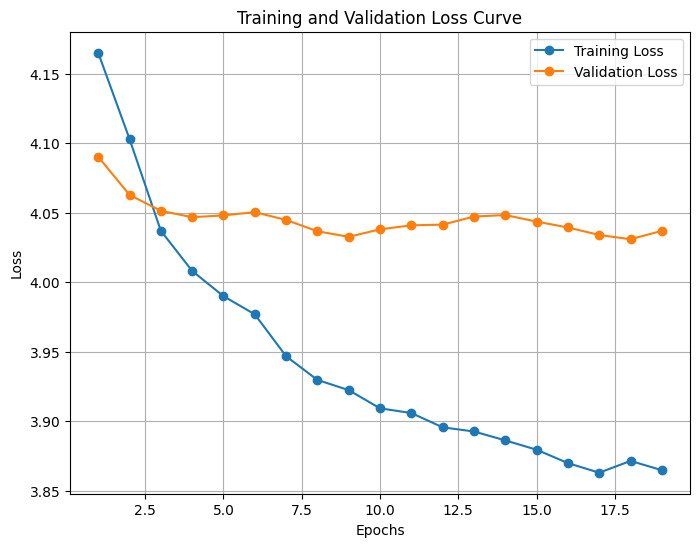

In [49]:
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(train_losses) + 1), train_losses, label="Training Loss", marker="o")
plt.plot(range(1, len(val_losses) + 1), val_losses, label="Validation Loss", marker="o")

plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss Curve")
plt.legend()
plt.grid()
plt.show()
# Nach dem Training: bestes Modell laden


# Test the best on test data

In [50]:

best_model_cosine_mapper.load_state_dict(torch.load("best_model_cosine_mapper_trained_with_test.pth"))
best_model_cosine_mapper.eval()
best_model_cosine_mapper.return_scores = False


# Listen zum Speichern der Vorhersagen
all_test_preds = []
all_test_labels = []

with torch.no_grad():
    for batch in test_loader:
        texts = batch["text"]
        labels = batch["label"].tolist()

        preds =best_model_cosine_mapper.predict(texts)
        print(labels)
        print(preds)
        
        all_test_preds.extend(preds)
        all_test_labels.extend(labels)






cm = confusion_matrix(all_test_labels, all_test_preds)

all_labels = sorted(set(all_test_labels) | set(all_test_preds))  # Vereinigung beider Mengen


tabs = []
titles = []

out0 = widgets.Output()
with out0:
    print(classification_report(all_test_labels, all_test_preds, digits=2))
tabs.append(out0)
titles.append("Calssification Report")

out1 = widgets.Output()
with out1:
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=False, fmt="d", cmap="Blues",
                    xticklabels=all_labels, 
                    yticklabels=all_labels)
        plt.title(f"Confusion Matrix: best_model_cosine_mapper_trained_with_test")
        plt.xlabel("Predicted Label")
        plt.ylabel("True Label")
        plt.tight_layout()
        plt.show()

tabs.append(out1)
titles.append("Confusion Matrix")


# Tabs anzeigen
tab_widget = widgets.Tab(children=tabs)
for i, title in enumerate(titles):
    tab_widget.set_title(i, title)

display(tab_widget)


[12, 1, 58, 3, 71, 24, 28, 63, 29, 35]
[45, 4, 13, 61, 72, 26, 28, 62, 29, 13]


# Finetuning without Test-data for ,,,,

# Init new Instanz of Cosine mapper

In [51]:
#del best_model_cosine_mapper

best_model_cosine_mapper = CosineMapper(
    model_name= url,
    label_embeddings=label_embeddings,
    pooling=pooling_strategy,
    threshold=threshold
)


# Prepare train vals split without test data  more val data

In [52]:

df = contract_sections_clean_labeled_manually.copy()

# Labels (int) extrahieren
df["label"] = df["catalog_id"].astype(int)

# Listen erzeugen
texts = df["clean_section_content"].tolist()
labels = df["label"].tolist()


# Split in Train/Test
train_texts, val_texts, train_labels, val_labels = train_test_split(
    texts, labels, test_size=0.3,  random_state=42
)



# class TextLabelDataset(Dataset):
#     def __init__(self, texts, labels):
#         self.texts = texts
#         self.labels = labels

#     def __len__(self):
#         return len(self.texts)

#     def __getitem__(self, idx):
#         return {
#             "text": self.texts[idx],
#             "label": self.labels[idx]
#         }

# train loader
train_dataset = TextLabelDataset(train_texts, train_labels)

train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=32,
    shuffle=True
)
del train_texts, train_labels, train_dataset

# validation loader
val_dataset = TextLabelDataset(val_texts, val_labels)

val_loader = DataLoader(
    dataset=val_dataset,
    batch_size=32,
    shuffle=False
)
del val_texts, val_labels, val_dataset


run testing

In [53]:
epochs = 1000  #number of epochs i.e. how many times is the whole dataset passed through the architecture
patience = 10  # Number of epochs to wait before stopping if no improvement
best_val_loss = float("inf")
patience_counter = 0
optim = AdamW(best_model_cosine_mapper.parameters(), lr=5e-5) 
best_model_cosine_mapper.train()
train_losses = []
val_losses = []
criterion = nn.CrossEntropyLoss()
best_val_loss = float("inf")
patience = 10
patience_counter = 0
best_model_cosine_mapper.return_scores=True


for epoch in range(epochs):
    best_model_cosine_mapper.train()
    train_total_loss = 0

    for batch in train_loader:
        texts = batch["text"]
        labels = batch["label"] -1
        optim.zero_grad()

        cos_sims = best_model_cosine_mapper(texts)  # cosine similarity (B, num_labels)
        loss = criterion(cos_sims, labels)

        train_total_loss += loss.item()
        loss.backward()
        optim.step()

    avg_train_loss = train_total_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    print(f"Epoch {epoch + 1}, Training Loss: {avg_train_loss:.4f}")

    # Validation
    best_model_cosine_mapper.eval()
    val_loss = 0
    all_val_preds = []
    all_val_labels = []

    with torch.no_grad():
        for batch in val_loader:
            texts = batch["text"]
            labels = batch["label"] -1

            cos_sims = best_model_cosine_mapper(texts)
            loss = criterion(cos_sims, labels)
            val_loss += loss.item()

            probs = torch.softmax(cos_sims, dim=1)
            preds = torch.argmax(probs, dim=1)

            all_val_preds.extend(preds.cpu().tolist())
            all_val_labels.extend(labels.cpu().tolist())

    avg_val_loss = val_loss / len(val_loader)
    val_losses.append(avg_val_loss)
    print(f"Epoch {epoch + 1}, Validation Loss: {avg_val_loss:.4f}")

    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        patience_counter = 0
        torch.save(best_model_cosine_mapper.state_dict(), "best_model_cosine_mapper_trained_with_test.pth")
        print("--> Model saved!")
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("XXX Early stopping triggered XXX")
            break


del batch, best_val_loss, patience, patience_counter, epoch
del loss, cos_sims, probs, preds, labels, texts, val_loss
del train_total_loss, optim, criterion, epochs
del all_val_preds, all_val_labels



Epoch 1, Training Loss: 4.1313
Epoch 1, Validation Loss: 4.1220
--> Model saved!
Epoch 2, Training Loss: 4.0745
Epoch 2, Validation Loss: 4.1016
--> Model saved!
Epoch 3, Training Loss: 4.0362
Epoch 3, Validation Loss: 4.0933
--> Model saved!
Epoch 4, Training Loss: 4.0040
Epoch 4, Validation Loss: 4.0880
--> Model saved!
Epoch 5, Training Loss: 3.9982
Epoch 5, Validation Loss: 4.0907
Epoch 6, Training Loss: 3.9508
Epoch 6, Validation Loss: 4.0968
Epoch 7, Training Loss: 3.9362
Epoch 7, Validation Loss: 4.1009
Epoch 8, Training Loss: 3.9369
Epoch 8, Validation Loss: 4.1032
Epoch 9, Training Loss: 3.9222
Epoch 9, Validation Loss: 4.1016
Epoch 10, Training Loss: 3.9123
Epoch 10, Validation Loss: 4.1016
Epoch 11, Training Loss: 3.9152
Epoch 11, Validation Loss: 4.1014


KeyboardInterrupt: 

# describe elarning rates and consequneces


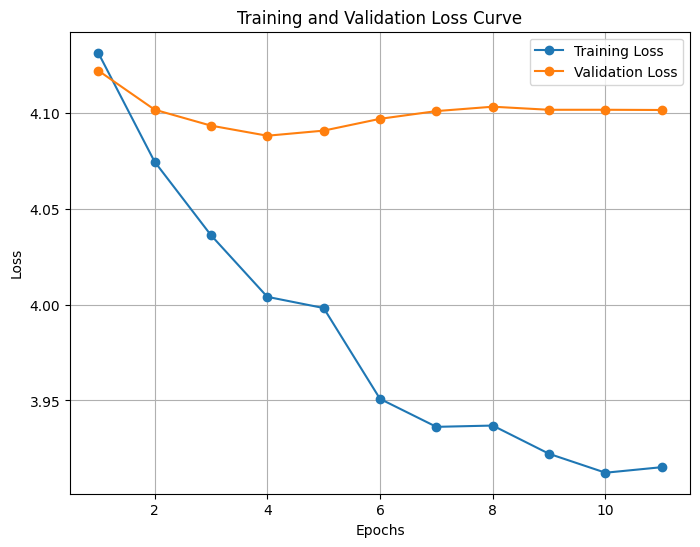

In [54]:
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(train_losses) + 1), train_losses, label="Training Loss", marker="o")
plt.plot(range(1, len(val_losses) + 1), val_losses, label="Validation Loss", marker="o")

plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss Curve")
plt.legend()
plt.grid()
plt.show()
# Nach dem Training: bestes Modell laden


# 6. Application + Textual checking of requirements 

In [55]:

contract_sections_clean_labeled_manually = pd.read_excel("../data/sections_labeled_manually.xlsx") 
df = contract_sections_clean_labeled_manually.copy()

catalogue_clean = pd.read_pickle("../data/catalogue_clean.pkl")
catalogue_clean["catalog_id"] = range(1, len(catalogue_clean) + 1)
display(catalogue_clean.head(5))

df = df[pd.notna(df["contract"])]
contracts_with_labels = df["contract"].astype(int).unique()
del df, contract_sections_clean_labeled_manually

all_contracts= pd.read_pickle("../data/contract_contents_german_only")
df = all_contracts.copy()
df["contract"] = df["contract"].astype(int)
contracts_without_labels = df[~df["contract"].isin(contracts_with_labels)]["contract"].unique().tolist()
exp_contract = contracts_without_labels[0]
print(exp_contract)
exp = df[df["contract"] == exp_contract]  # Beispiel: zufällige 1 Verträge
display(exp)

contract_sections_clean_without_labels = df[df["contract"].isin(contracts_without_labels)]


,paragraph_topic,section_topic,example,catalog_id
0,Projektkosten_und_Zahlungsmodalitäten,Sind sämtliche Kostenarten und -bestandteile (...,im festpreis von € sind sämtliche leistungen e...,1
1,Projektkosten_und_Zahlungsmodalitäten,Ist das Vergütungsmodell eindeutig festgelegt ...,der kunde zahlt eine monatliche pauschale von ...,2
2,Projektkosten_und_Zahlungsmodalitäten,Ist ein Zahlungsplan mit konkreten Fälligkeite...,die vergütung ist in drei raten zahlbar bei pr...,3
3,Projektkosten_und_Zahlungsmodalitäten,"Sind Währung, Rechnungsstellung, Zahlungsfrist...",alle preise verstehen sich in euro zuzüglich g...,4
4,Projektkosten_und_Zahlungsmodalitäten,Regelt der Vertrag den Umgang mit Nebenkosten ...,reise und übernachtungskosten werden nur ersta...,5


1


,contract,content
0,1,§ 1 Vertragsgegenstand 1.1 Der Anbieter stellt...


# Build new Cosine mapper instnace

In [56]:

best_models = pd.read_pickle("../data/best_models.pkl")
best_model_info = best_models.iloc[0]

url                 = best_model_info["model_url"]
pooling_strategy    = best_model_info["pooling_strategy"]
threshold           = best_model_info["optimal_threshold"]

catalogue_embeddings = add_embed_text_column(catalogue_clean, text_column="example", model=best_model, target_column="emb")
caltalogue_embeddings = torch.tensor(np.stack(catalogue_embeddings["emb"].to_list())).float()
catalogue_topics = catalogue_clean["section_topic"]

best_model_cosine_mapper_untrained = CosineMapper(
    model_name= url,
    label_embeddings=caltalogue_embeddings,
    pooling=pooling_strategy,
    threshold=threshold
)



Embedding example: 100%|██████████| 5/5 [00:00<00:00,  5.30it/s]


# build sectionTopicpredicort insance

In [57]:

topic_predictor = SectionTopicPredictor(best_model_cosine_mapper_untrained, catalogue_topics)

predict all the contracts that were totally unseen yet

In [58]:
top_scores = []
top_paragraphs = []
top_sections = []
top_indexes = []

# df = contract_sections_clean_without_labels.copy()

for i in contracts_without_labels:

    contract = contract_sections_clean_without_labels.loc[contract_sections_clean_without_labels["contract"] == i, "content"].iloc[0]
    df = topic_predictor.predict_contract(contract, return_topic_score=True)

    # Ausgabe (optional)
    #print(df.sort_values("score", ascending=False).head(1))
    df = df.sort_values("score", ascending=False)

    top_score = df.iloc[0]["score"]
    top_paragraph = df.iloc[0]["paragraph"]
    top_section = df.iloc[0]["section"]
    index_topscore = df[df["section"] == top_section].index[0]  # Index des Top-Scores
    top_scores.append(top_score)  
    top_paragraphs.append(top_paragraph)
    top_sections.append(top_section)  
    top_indexes.append(index_topscore)  

    
# Nach der Verarbeitung – temporäre Variablen löschen
del i, df, contract, top_score, top_section, index_topscore



# Show the top results

In [59]:
df_top_predictions = pd.DataFrame({
    "contract": contracts_without_labels,
    "prargaph": top_paragraphs,
    "section": top_sections,
    "score": top_scores,
    "index": top_indexes
})

display(df_top_predictions.sort_values("score", ascending= False))
    

,contract,prargaph,section,score,index
5,16,14.,14.2,0.6528,40
4,15,§ 4,4.2,0.5865,16
1,3,5.,5.2,0.5340,18
0,1,§ 1,1.2,0.4641,1
2,9,1.,1.1,0.4476,0
3,10,§ 1,(1),0.2600,0


# Show it for 1 example contract

In [60]:
df = contract_sections_clean_without_labels.copy()

exp = df[df["contract"] == 16] 

for i in range(len(exp)):  
    text = exp["content"].values[0]
    df = topic_predictor.predict_contract(text, return_topic_score=True)
    #print(predicted_df)

# Gute Kombi z.b contract 26 section 73
exp_section = 35 #random.randint(0, len(predicted_df) - 1)

topic = df.loc[exp_section, "predicted_topic"]
content = df.loc[exp_section, "section_content"]
score = df.loc[exp_section, "score"]

print("? Predicted Topic:\n", topic)
print("! Section Content:\n", content)
# Print Section Content in green color
print("\033[92m🔥 Score:\033[0m", score)

labeled_sections_example_contract = df.copy()
del df, exp, text, exp_section, topic, content, score

? Predicted Topic:
 Ist geregelt, wo die Kundendaten gespeichert/verarbeitet werden und unter welchen Bedingungen eine Übertragung in Drittstaaten zulässig ist?
! Section Content:
 12.1 Die Parteien sind verp#ichtet, alle ihnen im Zusammenhang mit diesem Vertrag bekannt gewordenen oder bekannt werdenden Informationen über die jeweils andere Partei, die als vertraulich gekennzeichnet werden oder anhand sonstiger Umstände als Geschäfts- und Betriebsgeheimnisse (im Folgenden: „vertrauliche Informationen“) erkennbar sind, dauerhaft geheim zu halten, nicht an Dritte weiterzugeben, aufzuzeichnen oder in anderer Weise zu verwerten, sofern die jeweils andere Partei der Offenlegung oder Verwendung nicht ausdrücklich und schriftlich zugestimmt hat oder die Informationen aufgrund Gesetzes, Gerichtsentscheidung oder einer Verwaltungsentscheidung offengelegt werden müssen.
🔥 Score: 0.5781


NEew structure:


In [61]:
df = labeled_sections_example_contract.copy()
display(df.head(5))
scores = df.sort_values("score")


,contract,paragraph,paragraph_content,section,section_content,clean_section_content,predicted_topic,score
0,1,1.,1. Vertragsgegenstand 1.1 Diese Vertragsbeding...,1.1,1.1 Diese Vertragsbedingungen gelten für die N...,diese vertragsbedingungen gelten für die nutzu...,Gibt es Vorgaben zur personellen Kontinuität b...,0.4630
1,1,1.,1. Vertragsgegenstand 1.1 Diese Vertragsbeding...,1.2,1.2 Die Software wird vom Anbieter als SaaS- b...,die software wird vom anbieter als saas bzw cl...,Werden die Folgen der Abnahme beschrieben (z.B...,0.4374
2,1,1.,1. Vertragsgegenstand 1.1 Diese Vertragsbeding...,1.3,1.3 Diese Vertragsbedingungen gelten ausschlie...,diese vertragsbedingungen gelten ausschließlic...,Sind die Rechte des Kunden im Gewährleistungsf...,0.4845
3,1,2.,2. Art und Umfang der Leistung Der Anbieter st...,no sections use paragraph,2. Art und Umfang der Leistung Der Anbieter st...,art und umfang der leistung der anbieter stell...,"Sind ausdrücklich Leistungen benannt, die nich...",0.5117
4,1,3.,3. Verfügbarkeit der Software 3.1 Der Anbieter...,3.1,"3.1 Der Anbieter weist den Kunden darauf hin, ...",der anbieter weist den kunden darauf hin dass ...,"Enthält der Vertrag eine Klausel, die den Kund...",0.5968


even newer struckture


In [62]:
display(df[["predicted_topic","section_content","score"]].head(5))
del df

,predicted_topic,section_content,score
0,Gibt es Vorgaben zur personellen Kontinuität b...,1.1 Diese Vertragsbedingungen gelten für die N...,0.4630
1,Werden die Folgen der Abnahme beschrieben (z.B...,1.2 Die Software wird vom Anbieter als SaaS- b...,0.4374
2,Sind die Rechte des Kunden im Gewährleistungsf...,1.3 Diese Vertragsbedingungen gelten ausschlie...,0.4845
3,"Sind ausdrücklich Leistungen benannt, die nich...",2. Art und Umfang der Leistung Der Anbieter st...,0.5117
4,"Enthält der Vertrag eine Klausel, die den Kund...","3.1 Der Anbieter weist den Kunden darauf hin, ...",0.5968


# 7. Evaluate Contract Sections

To assess how well contract sections fulfill the previously defined core aspects, we used an LLM-based evaluation approach. We used a structured prompt that included the section text and a list of core aspects. The LLM (GPT-4o-mini) then returned individual scores for each core aspect and an overall fulfillment percentage. This allows us to measure compliance in a structured and scalable way. 



# 7.2 Define LLM Evaluation Function
In this step, we define the core function that sends contract section texts and their associated core aspects to the LLM (GPT-4o-mini) for evaluation. The function check_core_aspects_with_llm() takes a section and a list of aspects, builds a structured prompt, sends it to the OpenAI API, and returns the model's response.

The prompt used here is engineered for reliable outputs:

- Specific role assignment: The LLM is instructed to act as a contract expert, which helps guide its reasoning in a specialized domain.

- Clear task description: The prompt asks the model to evaluate how well each core aspect is fulfilled using a scoring scale from 0 to 1.

- Enforced output format: A JSON structure is provided as a strict template for the response, ensuring consistency and simplifying parsing later.

This design helps the model understand exactly what is expected and improves the consistency of results across evaluations

In [63]:
client = OpenAI(api_key=OpenAiKey)

# 7.3 Join Predictions with Core Aspects
To prepare the data for evaluation, we first merge the predicted topics with their corresponding core aspects. This is done by joining the predicted_df (which contains each section's predicted topic) with the catalogue that maps each topic to a set of core aspects.

After the merge, we select only the necessary columns to form a clean evaluation dataset. This merged dataframe (df_eval) will be used in the following steps for LLM evaluation.

In [64]:
df = labeled_sections_example_contract.copy()
catalogue_clean_with_aspects = pd.read_excel("../data/catalogue_clean_with_aspects.xlsx")


df = df.merge(
    catalogue_clean_with_aspects[["section_topic", "core_aspects"]],
    left_on="predicted_topic",
    right_on="section_topic",
    how="left")

# df_eval = df_eval[["contract", "paragraph", "section", "clean_section_content", "predicted_topic", "core_aspects"]]
df = df[["contract", "paragraph", "section", "section_content", "predicted_topic","score", "core_aspects"]]

display(df.head(5) )

labeled_sections_example_contract_with_critertia = df.copy()
del df, catalogue_clean_with_aspects

,contract,paragraph,section,section_content,predicted_topic,score,core_aspects
0,1,1.,1.1,1.1 Diese Vertragsbedingungen gelten für die N...,Gibt es Vorgaben zur personellen Kontinuität b...,0.4630,"Schlüsselpersonal (z. B. Projektleiter, leiten..."
1,1,1.,1.2,1.2 Die Software wird vom Anbieter als SaaS- b...,Werden die Folgen der Abnahme beschrieben (z.B...,0.4374,Die Fälligkeit der Schlusszahlung ist an die e...
2,1,1.,1.3,1.3 Diese Vertragsbedingungen gelten ausschlie...,Sind die Rechte des Kunden im Gewährleistungsf...,0.4845,Die Rechte des Kunden im Gewährleistungsfall s...
3,1,2.,no sections use paragraph,2. Art und Umfang der Leistung Der Anbieter st...,"Sind ausdrücklich Leistungen benannt, die nich...",0.5117,Kundenseitige Mitwirkungspflichten sind konkre...
4,1,3.,3.1,"3.1 Der Anbieter weist den Kunden darauf hin, ...","Enthält der Vertrag eine Klausel, die den Kund...",0.5968,Der Anbieter verpflichtet sich zur Freistellun...


# 7.4 Evaluate and Parse LLM Results
We apply the LLM evaluation function to all of the mapped sections of the example contract. For each section, we extract the relevant core aspects, send them with the section content to the LLM, and receive structured feedback.

The evaluate_llm function handles the API call and tries to extract a valid JSON result. This ensures we can reliably parse the core aspect scores and the overall fulfillment percentage. The results are then added back to the dataframe, making it ready for further analysis.

In [65]:
df = labeled_sections_example_contract_with_critertia.copy()
df["llm_eval_result"] = df.apply(lambda x: evaluate_fullfillment_on_criteria(x
                                                                            , model = "gpt-4o-mini"
                                                                            , content_column ="section_content"
                                                                            , criteria_column="core_aspects"
                                                                            , client=client)
                                                                            , axis=1)



df.loc[df.index, "llm_eval_result"] = df["llm_eval_result"]

df["core_aspect_scores"] = df["llm_eval_result"].apply(
    lambda x: x.get("core_aspect_scores", {}) if isinstance(x, dict) else {}
)
df["average_fulfillment_percent"] = df["llm_eval_result"].apply(
    lambda x: x.get("average_fulfillment_percent") if isinstance(x, dict) else None
)


example_contract_labeld_and_evaluated = df.copy()
example_contract_labeld_and_evaluated .to_pickle("../data/example_contract_labeld_and_evaluated.pkl")
example_contract_labeld_and_evaluated .to_excel("../data/example_contract_labeld_and_evaluated..xlsx", index=False)

del df

✅ LLM-Antwort: {
    "core_aspect_scores": {
        "Schlüsselpersonal ist namentlich benannt": 0,
        "Wechsel von Schlüsselpersonal nur mit Zustimmung des Kunden": 0,
        "Ersatzpersonen müssen über vergleichbare Qualifikationen verfügen": 0,
        "Einarbeitung der Ersatzperson in projektrelevante Details": 0,
        "Sicherstellung der personellen Kontinuität vertraglich geregelt": 0
    },
    "average_fulfillment_percent": 0
}
✅ LLM-Antwort: {
    "core_aspect_scores": {
        "Die Fälligkeit der Schlusszahlung ist an die erfolgte Abnahme gekoppelt.": 0,
        "Die vertraglichen Leistungen gelten mit Abnahme als erfüllt.": 0.5,
        "Die Gewährleistungsfrist beginnt mit dem Abnahmezeitpunkt.": 0,
        "Der Beginn der Gewährleistung ist zeitlich klar definiert (z. B. „ab Abnahme“).": 0,
        "Es wird ein klarer Zusammenhang zwischen Abnahme und vertraglichen Folgepflichten hergestellt (z. B. Zahlung, Fristenbeginn).": 0
    },
    "average_fulfillment_perc

# Resluting in 

In [66]:
df = example_contract_labeld_and_evaluated.copy()
# Nur Zeilen anzeigen, bei denen "average_fulfillment_percent" nicht None ist
df = df[df["average_fulfillment_percent"].notnull()].sort_values("average_fulfillment_percent", ascending=False).head()
display(df)

def insert_linebreaks_every_n_chars(text, n=100):
    return '\n'.join(text[i:i+n] for i in range(0, len(text), n))

if not df.empty:
	first_row = df.iloc[1]

	tabs = []
	titles = []

	out0 = widgets.Output()
	with out0:
		print(insert_linebreaks_every_n_chars(first_row["section_content"], n=200))
	tabs.append(out0)
	titles.append("section content")

	out1 = widgets.Output()
	with out1:
		print(f'mapped to : {first_row["predicted_topic"]}')
	tabs.append(out1)
	titles.append("topic")

	out2 = widgets.Output()
	with out2:
		print(f'{first_row["core_aspects"]}'.replace(",",",\n"))
	tabs.append(out2)
	titles.append("core aspecs")

	out3 = widgets.Output()
	with out3:
		print(f'{first_row["core_aspect_scores"]}')
	tabs.append(out3)
	titles.append("single scores")

	out4 = widgets.Output()
	with out4:
		print(f'average fulfillment percent: {first_row["average_fulfillment_percent"]}%')   
	tabs.append(out4)
	titles.append("avg score")

	tab_widget = widgets.Tab(children=tabs)
	for i, title in enumerate(titles):
		tab_widget.set_title(i, title)

	display(tab_widget)


,contract,paragraph,section,section_content,predicted_topic,score,core_aspects,llm_eval_result,core_aspect_scores,average_fulfillment_percent
24,1,9.,9.3,9.3 Bei Verletzung einer Kardinalp#icht ist di...,Ist die Haftung der Höhe nach begrenzt (z.B. a...,0.5169,Es ist eine ausdrückliche Haftungsbegrenzung i...,{'core_aspect_scores': {'Es ist eine ausdrückl...,{'Es ist eine ausdrückliche Haftungsbegrenzung...,60.0
39,1,14.,14.1,14.1 Diese Vereinbarung und ihre Änderungen so...,Gibt es einen formalen Prozess für Leistungsän...,0.5942,Leistungsänderungen müssen vom Kunden in Form ...,{'core_aspect_scores': {'Leistungsänderungen m...,{'Leistungsänderungen müssen vom Kunden in For...,60.0
18,1,7.,7.2,7.2 Die ordnungsgemäße und regelmäßige Sicheru...,"Bleibt klargestellt, dass alle vom Kunden stam...",0.5495,Eigentum der Kundendaten liegt ausdrücklich be...,{'core_aspect_scores': {'Eigentum der Kundenda...,{'Eigentum der Kundendaten liegt ausdrücklich ...,50.0
32,1,11.,11.2,11.2 Die außerordentliche Kündigung aus wichti...,"Sind wichtige Kündigungsgründe definiert, die ...",0.5875,Das Recht zur außerordentlichen Kündigung aus ...,"{'core_aspect_scores': {'Aspekt 1': 1, 'Aspekt...","{'Aspekt 1': 1, 'Aspekt 2': 0.5, 'Aspekt 3': 0...",40.0
7,1,4.,4.2,4.2 Der Kunde räumt dem Anbieter für die Zweck...,"Bleibt klargestellt, dass alle vom Kunden stam...",0.6107,Eigentum der Kundendaten liegt ausdrücklich be...,{'core_aspect_scores': {'Eigentum der Kundenda...,{'Eigentum der Kundendaten liegt ausdrücklich ...,40.0


# Das hier ist dann natürlich 8. ...

## 7. Outlook and Next Steps

While the current system demonstrates solid foundations—including a clause-matching pipeline, LLM-based scoring, and an extensible structure—there are several technical, methodological, and user-facing developments that can greatly enhance the tool’s effectiveness and robustness. Below, we outline the key next steps and areas for improvement:

---

### 7.1. Expand the Clause Catalogue and Prompt Set

At the heart of the scoring process lies a curated catalogue of core aspects—each representing a contractual requirement such as data protection, liability limitations, or termination rights. Currently, these prompts were generated semi-manually and vary in specificity. To improve consistency and coverage, the following should be considered:

- **Expert-Curated Prompts**: Collaborate with legal professionals to ensure that core aspect prompts are formulated in precise, legally sound language.
- **Add More Examples**: Enrich each core aspect with example clauses, both positive (compliant) and negative (non-compliant), to give models more grounding.
- **Structure the Catalogue Hierarchically**: Group related aspects (e.g., under a “Data Protection” parent) to better organize feedback and support scalable training.

---

### 7.2. Integrate Feedback Loops and Expert Review

A crucial step toward production-readiness is the inclusion of expert review to validate and calibrate the tool’s assessments. This includes:

- **Expert Evaluation of GPT Scores**: Have legal professionals verify whether high GPT fulfillment scores truly reflect legal adequacy.
- **Error Analysis**: Examine false positives and false negatives to improve prompt design and model behavior.
- **Feedback-Guided Fine-Tuning**: If resources allow, fine-tune a smaller model on a curated, expert-labeled dataset to improve domain specificity.

---

### 7.3. Detect Anomalies and Suspicious Matches

Not all clause matches are trustworthy. Despite good semantic similarity, LLMs may confidently score irrelevant or loosely related content. Suggested improvements:

- **Outlier Detection Logic**: Flag low-confidence or inconsistent matches for additional review.
- **Similarity Thresholds**: Introduce minimum cosine similarity thresholds to reduce noise in paragraph matching.
- **Secondary Validation Model**: Develop a lightweight classifier to identify and flag questionable LLM outputs.

---

### 7.4. Merge Pipeline Logic into Unified Components

Currently, the system operates across loosely coupled Jupyter notebooks. For modularity and scalability:

- **Introduce a `ContractChecker` Class**: Encapsulate key steps—input parsing, section mapping, scoring, and aggregation—into a single, reusable Python class.
- **Wrap the Pipeline into a Service**: Develop the architecture as a callable backend service to support frontend integration.

---

### 7.5. Enhance Reliability and Error Handling

LLM-based systems are prone to failure in subtle ways, especially during high-throughput or edge cases. To improve reliability:

- **Strict Output Parsing**: Validate GPT outputs against well-defined schemas and provide fallback logic.
- **Retry Logic for API Calls**: Add exponential backoff and error logging for network resilience and rate limit handling.
- **Model Confidence Signals**: Investigate if LLMs can self-report uncertainty or use auxiliary scoring models to weight results accordingly.

---

### 7.6. Benchmark and Compare More LLMs

Our current prototype relies on OpenAI's GPT-4, which may not be optimal in every aspect. The following actions are recommended:

- **Compare Alternative LLMs**: Evaluate Claude 3, Gemini 1.5, Mistral, and open-source models for cost, latency, and interpretability.
- **Latency and Cost Trade-Offs**: Consider model selection based on batch vs. real-time needs.
- **Check for Model Bias**: Audit whether certain models over- or under-score based on stylistic differences in legal language.

---

### 7.7. Deploy a User-Facing Interface

The full utility of the system depends on ease of access and clarity for end-users. Building on the frontend prototype:

- **Streamlit or Flask App**: Offer drag-and-drop uploads, section-wise results, and downloadable summaries.
- **Interactive Highlighting**: Let users inspect failed aspects and view the responsible text fragments directly.
- **User Feedback Loop**: Provide mechanisms for users to report scoring inaccuracies and integrate feedback into future iterations.

---

## 8. Conclusion

This project demonstrates the potential of combining structured legal knowledge with advanced natural language models to build a smart, explainable contract review assistant. The current pipeline—from clause extraction to LLM-based evaluation—offers a proof of concept that is already functional and extensible. 

However, true deployment will require rigorous validation, broader model experimentation, and meaningful involvement of legal professionals. The integration of explainability and anomaly detection will be key to building trust in automated evaluations. Likewise, usability improvements such as interface development and expert feedback integration will determine the system’s real-world adoption.

In sum, the project lays the groundwork for a hybrid review system where human expertise is augmented—not replaced—by intelligent tooling. Continued development along the proposed lines can elevate this prototype into a practical and reliable assistant in legal operations, particularly for organizations handling a high volume of standardized contracts.